#### Read packages

In [26]:
# Basic: 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from IPython.display import display
%matplotlib inline
from tqdm import tqdm

# Features, and other misc.:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Models:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from keras.layers import Dense, Flatten, Embedding, Dropout, SpatialDropout1D 
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D 
from keras.layers import Bidirectional
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential 
import xgboost as xgb

# Metrics:
from sklearn.metrics import log_loss, roc_auc_score, make_scorer
from sklearn.metrics import make_scorer
import datetime
import re

### Read data

In [27]:
listdir("../input/")

['test.csv', 'train.csv']

In [28]:
train_raw = pd.read_csv("../input/train.csv")
test_raw = pd.read_csv("../input/test.csv")
print(train_raw.shape, test_raw.shape)
display(train_raw.head())
display(test_raw.head())

(19579, 3) (8392, 2)


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


### Data analysis and cleanup:

In [29]:
# Is data clean and mem usage
train_raw.info()
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
id        19579 non-null object
text      19579 non-null object
author    19579 non-null object
dtypes: object(3)
memory usage: 459.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 2 columns):
id      8392 non-null object
text    8392 non-null object
dtypes: object(2)
memory usage: 131.2+ KB


EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

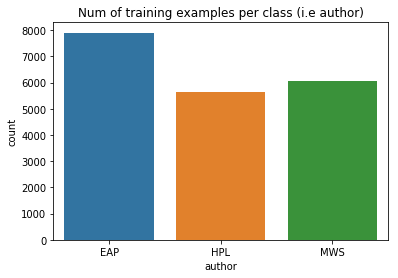

In [30]:
# Is number of training examples per class balanced?
plt.figure()
sns.countplot(x='author',data=train_raw)
#sns.countplot(train.author)
plt.title("Num of training examples per class (i.e author)");
train_raw['author'].value_counts()

In [31]:
# Peak at the sentences:
for author in ["EAP", "MWS", "HPL"]:
    print("===" + str(author) + "===")
    for i in range(3):
        display(train_raw[train_raw['author'] == author]['text'].iloc[i])

===EAP===


'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

'In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.'

'The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.'

===MWS===


'How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.'

'A youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship: I have never believed it to be necessary, and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew, I felt myself peculiarly fortunate in being able to secure his services.'

'I confess that neither the structure of languages, nor the code of governments, nor the politics of various states possessed attractions for me.'

===HPL===


'It never once occurred to me that the fumbling might be a mere mistake.'

'Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.'

'Herbert West needed fresh bodies because his life work was the reanimation of the dead.'

,id,text,author,num_punctuations,num_stopwords,num_words
0,id26305,"This process, however, afforded me no means of...",EAP,7,19,41
1,id17569,It never once occurred to me that the fumbling...,HPL,1,8,14
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,5,16,36
3,id27763,How lovely is spring As we looked from Windsor...,MWS,4,13,34
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,4,11,27


,id,text,num_punctuations,num_stopwords,num_words
0,id02310,"Still, as I urged our leaving Ireland with suc...",3,9,19
1,id24541,"If a fire wanted fanning, it could readily be ...",7,33,62
2,id00134,And when they had broken down the frail door t...,3,15,33
3,id27757,While I was thinking how I should possibly man...,5,19,41
4,id04081,I am not sure to what limit his knowledge may ...,1,6,11


This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
num_punctuations ---> 7
num_stopwords ---> 19
num_words ---> 41
It never once occurred to me that the fumbling might be a mere mistake.
num_punctuations ---> 1
num_stopwords ---> 8
num_words ---> 14
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
num_punctuations ---> 5
num_stopwords ---> 16
num_words ---> 36
How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.
num_punctuations ---> 4
num_stopwords ---> 13
num_words ---> 34


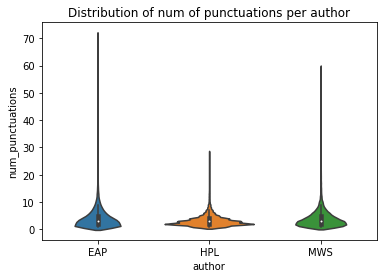

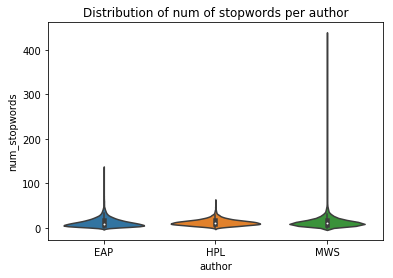

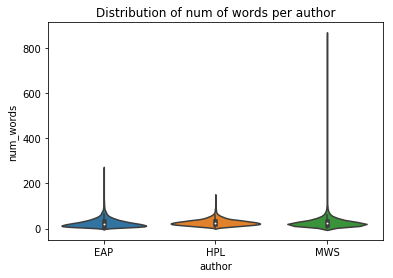

In [32]:
# Check stop words and punctuation per author:
# Add them as features:

# Punctuations:
train_raw['num_punctuations'] = train_raw['text'].apply(lambda x: len([char for char in str(x) if char in string.punctuation]))
test_raw['num_punctuations'] = test_raw['text'].apply(lambda x: len([char for char in str(x) if char in string.punctuation]))

# Stopwords:
train_raw['num_stopwords'] = train_raw['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in stopwords.words("english")]))
test_raw['num_stopwords'] = test_raw['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in stopwords.words("english")]))

# Num of words:
train_raw['num_words'] = train_raw['text'].apply(lambda x: len([word for word in str(x).lower().split()]))
test_raw['num_words'] = test_raw['text'].apply(lambda x: len([word for word in str(x).lower().split()]))

#print(train_raw.loc[0:4]['text'])
#print(train_raw['num_punctuations'][0:4])
display(train_raw.head())
display(test_raw.head())
for idx in range(4):
    print(train_raw.loc[idx]['text'])
    print("num_punctuations ---> " + str(train_raw['num_punctuations'][idx]))
    print("num_stopwords ---> " + str(train_raw['num_stopwords'][idx]))
    print("num_words ---> " + str(train_raw['num_words'][idx]))

## Plot
plt.figure()
plt.title("Distribution of num of punctuations per author");
sns.violinplot(x='author',y='num_punctuations',data = train_raw)
plt.figure()
plt.title("Distribution of num of stopwords per author");
sns.violinplot(x='author',y='num_stopwords',data = train_raw)
plt.figure()
plt.title("Distribution of num of words per author");
sns.violinplot(x='author',y='num_words',data = train_raw)

### Encode the output as numerical data for training

In [33]:
# Encode the output labels as 3 classes (from string to int)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_raw['author'])
y_train_raw = label_encoder.fit_transform(train_raw['author'])
print(label_encoder.classes_)
print(label_encoder.transform(['EAP','HPL','MWS']))

# Store inverse transform for submissions csv
print(label_encoder.inverse_transform([0,1,2]))
label_inv_transform = label_encoder.inverse_transform([0,1,2])
print(label_encoder.inverse_transform([0]))

['EAP' 'HPL' 'MWS']
[0 1 2]
['EAP' 'HPL' 'MWS']
['EAP']


### Baseline accuracy

In [34]:
## Submission file function

# Given prob, print it to file
def create_submission_final(model_name, predictions_prob):

    subm_file = model_name+'_submission.csv'
    print("Creating submission file: " + str(subm_file))
    
    # Get probabilities
    test_id_values = test_raw['id'].values
    #print(predictions[::100])
    #print(predictions_prob[::100])

    # Print to file
    op_file = pd.DataFrame()
    op_file['id'] = test_id_values
    op_file[label_inv_transform[0]] = predictions_prob[:,0] ; # EAP
    op_file[label_inv_transform[1]] = predictions_prob[:,1] ; # HPL
    op_file[label_inv_transform[2]] = predictions_prob[:,2] ; # MWS
    op_file.to_csv(subm_file,index=False)

In [35]:
# Baseline accuracy:
baseline_prob = np.tile(np.array([1,0,0]), (8392,1))
create_submission_final("baseline_1", baseline_prob)

Creating submission file: baseline_1_submission.csv


### K-fold training function: It will be used throughout this notebook
#### Also, includes function to add predictions as features

In [36]:
#############################
# K-fold CV training function:
#############################
# Inputs: x_train (includes y labels), y_train (only y labels), x_test
# Preprocess train_raw, test_raw to give x_train, y_train, x_test
def run_kfold_training(model_name, 
                       run_model_preprocess, model_preprocess_params,
                       run_model, model_params,
                       algorithm_type,
                       x_train_raw, y_train_raw, x_test_raw,
                       kfold_idx_not_on_df):

    # Print some messages
    print("Running kfold training with model", model_name)
    print("Shapes: x_train_raw.shape {}, y_train_raw.shape {} , x_test_raw.shape {}".format(
        x_train_raw.shape, y_train_raw.shape, x_test_raw.shape))
    
    # Preprocess the data to input to the model
    print("Running preprocess:", run_model_preprocess)
    (x_train, x_test, 
     extra_params) = run_model_preprocess(x_train_raw, x_test_raw, model_preprocess_params)
    y_train = y_train_raw
    print("Shapes: x_train.shape {}, y_train.shape {} , x_test.shape {}".format(
        x_train.shape, y_train.shape, x_test.shape))
    
    
    # Add extra params to model_params dictionary to pass to running the model
    if extra_params is not None:
        for k,v in extra_params.items():
            model_params[k] = v
    
    # Type of split
    num_splits = 5
    kf = KFold(n_splits = num_splits, shuffle=True, random_state = 1)
    
    # Num of classes in the output
    num_classes = 3
    
    # train and test predictions (could be added as stacking features later)
    pred_test = 0
    pred_train = np.zeros((x_train_raw.shape[0], num_classes))
    
    # val_scores
    val_scores = []
    
   
    # Kfold training and prediction
    fold_num = 0
    for train_folds_idx, val_fold_idx in kf.split(x_train_raw):

        fold_num+=1
        print("Running fold", fold_num)
        
        # Get the train and validation folds (Dataframe idx needs .loc)
        if kfold_idx_not_on_df == 1:
            x_train_folds, x_val_fold = x_train[train_folds_idx], x_train[val_fold_idx]
        else:
            x_train_folds, x_val_fold = x_train.loc[train_folds_idx], x_train.loc[val_fold_idx]
        y_train_folds, y_val_fold = y_train[train_folds_idx], y_train[val_fold_idx]
        
        # Fit 
        (pred_val_fold, pred_test_per_fold_training, 
         model) = run_model(x_train_folds, y_train_folds, 
                            x_val_fold, y_val_fold,
                            x_test,
                            model_params)
        
        # Compile predictions on validation fold (i.e. unseen data)
        pred_train[val_fold_idx,:] = pred_val_fold
        # Compile predictions on test set using current training folds model
        pred_test += pred_test_per_fold_training
        val_scores.append(log_loss(y_val_fold, pred_val_fold))

    pred_test = pred_test * (1. / num_splits) 
    print("\n\n===== Model: {}  ========:".format(model_name))
    print(" Cross-val log losses are:", val_scores)
    print("====== Mean cross-val log loss is: {} =========\n\n".format(np.mean(val_scores)))

    return pred_train, pred_test, model

#########################################
# Function to add predictions as features
#########################################
def add_pred_features(modelname, x_train, x_test, pred_train, pred_test):
    
    feature_eap = modelname + '_eap'
    feature_hpl = modelname + '_hpl'
    feature_mws = modelname + '_mws'
    x_train[feature_eap] = pred_train[:,0]
    x_train[feature_hpl] = pred_train[:,1]
    x_train[feature_mws] = pred_train[:,2]
    x_test[feature_eap] = pred_test[:,0]
    x_test[feature_hpl] = pred_test[:,1]
    x_test[feature_mws] = pred_test[:,2]
    
    return x_train, x_test

### Pre-processing and Supervised Machine learning algorithms:
- CountVectorizer, TfidfVectorizer
- Multinominal Naive Bayes (MNB), Logistic Regression (LR)

In [37]:
# Tfidf vectorizer with MNB:
def gen_tfidf(x_train_text, x_test_text):
    ngram = 2
    #vect = TfidfVectorizer(stop_words='english', ngram_range = (1,ngram)).fit(x_train)
    vect = TfidfVectorizer(ngram_range = (1,ngram)).fit(x_train_text)
    x_train_doc_term = vect.transform(x_train_text)
    x_test_doc_term = vect.transform(x_test_text)
    return x_train_doc_term, x_test_doc_term

# Run mnb on tfidf
def run_mnb_tfidf(x_train, x_test, params = None):
    # Separate out text
    x_train_text = x_train['text']
    x_test_text = x_test['text']
    # Get tfidf doc term matrix
    x_train_doc_term, x_test_doc_term = gen_tfidf(x_train_text, x_test_text) 
    return x_train_doc_term, x_test_doc_term, None

# Multinomial Naive bayes algorithm
def run_mnb(x_train, y_train, x_val, y_val, x_test, params):
    alpha = params['alpha']
    model = MultinomialNB(alpha = alpha)
    model.fit(x_train, y_train)
    pred_val = model.predict_proba(x_val)
    pred_test = model.predict_proba(x_test)
    return pred_val, pred_test, model   

# Run MNB tfidf and add predictions as features:
model_name = "mnb_tfidf"
model_preprocess_function = run_mnb_tfidf
model_function = run_mnb
model_params = {'alpha': 0.01 }
model_preprocess_params = None
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "VECT", 
                                           train_raw, y_train_raw, test_raw, 1)                                           
train_raw, test_raw = add_pred_features(model_name, 
                                        train_raw, test_raw, 
                                        pred_train, pred_test)
#display(train_raw.head(1))
#display(test_raw.head(1))

Running kfold training with model mnb_tfidf
Shapes: x_train_raw.shape (19579, 6), y_train_raw.shape (19579,) , x_test_raw.shape (8392, 5)
Running preprocess: <function run_mnb_tfidf at 0x7f64f5860e18>
Shapes: x_train.shape (19579, 249062), y_train.shape (19579,) , x_test.shape (8392, 249062)
Running fold 1
Running fold 2
Running fold 3
Running fold 4
Running fold 5


===== Model: mnb_tfidf  ========:
 Cross-val log losses are: [0.37908346999014125, 0.37106918023241087, 0.37236379382643092, 0.37617292752863873, 0.36991758602498825]
====== Mean cross-val log loss is: 0.373721391520522 =========




In [38]:
# Count vectorizer with MNB:
def gen_count(x_train_text, x_test_text):
    ngram = 2
    vect = CountVectorizer(stop_words='english', ngram_range = (1,ngram)).fit(x_train_text)
    x_train_doc_term = vect.transform(x_train_text)
    x_test_doc_term = vect.transform(x_test_text)
    return x_train_doc_term, x_test_doc_term

# Run mnb on tfidf
def run_mnb_count(x_train, x_test, params = None):
    # Separate out text
    x_train_text = x_train['text']
    x_test_text = x_test['text']
    # Get tfidf doc term matrix
    x_train_doc_term, x_test_doc_term = gen_count(x_train_text, x_test_text) 
    return x_train_doc_term, x_test_doc_term, None

# Multinomial Naive bayes algorithm
def run_mnb(x_train, y_train, x_val, y_val, x_test, params):
    alpha = params['alpha']
    model = MultinomialNB(alpha = alpha)
    model.fit(x_train, y_train)
    pred_val = model.predict_proba(x_val)
    pred_test = model.predict_proba(x_test)
    return pred_val, pred_test, model 

# Run MNB count and add predictions as features:
model_name = "mnb_count"
model_preprocess_function = run_mnb_count
model_function = run_mnb
model_params = {'alpha': 1.0 }
model_preprocess_params = None
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "VECT", 
                                           train_raw, y_train_raw, test_raw, 1)                                           
train_raw, test_raw = add_pred_features(model_name, 
                                        train_raw, test_raw, 
                                        pred_train, pred_test)
display(train_raw.head(1))
display(test_raw.head(1))

Running kfold training with model mnb_count
Shapes: x_train_raw.shape (19579, 9), y_train_raw.shape (19579,) , x_test_raw.shape (8392, 8)
Running preprocess: <function run_mnb_count at 0x7f64a2b12510>
Shapes: x_train.shape (19579, 212575), y_train.shape (19579,) , x_test.shape (8392, 212575)
Running fold 1
Running fold 2
Running fold 3
Running fold 4
Running fold 5


===== Model: mnb_count  ========:
 Cross-val log losses are: [0.46875532098312317, 0.45116954365731066, 0.43660145956478208, 0.46107245572976219, 0.44702080768041885]
====== Mean cross-val log loss is: 0.45292391752307937 =========




,id,text,author,num_punctuations,num_stopwords,num_words,mnb_tfidf_eap,mnb_tfidf_hpl,mnb_tfidf_mws,mnb_count_eap,mnb_count_hpl,mnb_count_mws
0,id26305,"This process, however, afforded me no means of...",EAP,7,19,41,0.942005,0.01129,0.046705,0.999989,0.000007,0.000004


,id,text,num_punctuations,num_stopwords,num_words,mnb_tfidf_eap,mnb_tfidf_hpl,mnb_tfidf_mws,mnb_count_eap,mnb_count_hpl,mnb_count_mws
0,id02310,"Still, as I urged our leaving Ireland with suc...",3,9,19,0.07408,0.004957,0.920963,0.038465,0.000992,0.960543


In [39]:
# Tfidf vectorizer with MNB at char level:
def gen_tfidf_char(x_train_text, x_test_text):
    ngram = 7
    #vect = TfidfVectorizer(stop_words='english', ngram_range = (1,ngram)).fit(x_train)
    vect = TfidfVectorizer(ngram_range = (1,ngram), analyzer='char').fit(x_train_text)
    x_train_doc_term = vect.transform(x_train_text)
    x_test_doc_term = vect.transform(x_test_text)
    return x_train_doc_term, x_test_doc_term

# Run mnb on tfidf
def run_mnb_tfidf_char(x_train, x_test, params = None):
    # Separate out text
    x_train_text = x_train['text']
    x_test_text = x_test['text']
    # Get tfidf doc term matrix
    x_train_doc_term, x_test_doc_term = gen_tfidf_char(x_train_text, x_test_text) 
    return x_train_doc_term, x_test_doc_term, None

# Multinomial Naive bayes algorithm
def run_mnb(x_train, y_train, x_val, y_val, x_test, params):
    alpha = params['alpha']
    model = MultinomialNB(alpha = alpha)
    model.fit(x_train, y_train)
    pred_val = model.predict_proba(x_val)
    pred_test = model.predict_proba(x_test)
    return pred_val, pred_test, model  

# Run MNB tfidf chars and add predictions as features:
model_name = "mnb_tfidf_char"
model_preprocess_function = run_mnb_tfidf_char
model_function = run_mnb
model_params = {'alpha': 0.03 }
model_preprocess_params = None
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "VECT", 
                                           train_raw, y_train_raw, test_raw, 1)                                           
train_raw, test_raw = add_pred_features(model_name, 
                                        train_raw, test_raw, 
                                        pred_train, pred_test)


display(train_raw.head(1))
display(test_raw.head(1))

Running kfold training with model mnb_tfidf_char
Shapes: x_train_raw.shape (19579, 12), y_train_raw.shape (19579,) , x_test_raw.shape (8392, 11)
Running preprocess: <function run_mnb_tfidf_char at 0x7f64a2b7f6a8>
Shapes: x_train.shape (19579, 1151052), y_train.shape (19579,) , x_test.shape (8392, 1151052)
Running fold 1
Running fold 2
Running fold 3
Running fold 4
Running fold 5


===== Model: mnb_tfidf_char  ========:
 Cross-val log losses are: [0.38824197963183649, 0.3890223276436871, 0.39628563464291233, 0.3847979523816813, 0.37640460557993577]
====== Mean cross-val log loss is: 0.3869504999760106 =========




,id,text,author,num_punctuations,num_stopwords,num_words,mnb_tfidf_eap,mnb_tfidf_hpl,mnb_tfidf_mws,mnb_count_eap,mnb_count_hpl,mnb_count_mws,mnb_tfidf_char_eap,mnb_tfidf_char_hpl,mnb_tfidf_char_mws
0,id26305,"This process, however, afforded me no means of...",EAP,7,19,41,0.942005,0.01129,0.046705,0.999989,0.000007,0.000004,0.999451,0.000059,0.00049


,id,text,num_punctuations,num_stopwords,num_words,mnb_tfidf_eap,mnb_tfidf_hpl,mnb_tfidf_mws,mnb_count_eap,mnb_count_hpl,mnb_count_mws,mnb_tfidf_char_eap,mnb_tfidf_char_hpl,mnb_tfidf_char_mws
0,id02310,"Still, as I urged our leaving Ireland with suc...",3,9,19,0.07408,0.004957,0.920963,0.038465,0.000992,0.960543,0.00035,0.000036,0.999614


In [40]:
# Count vectorizer with Logistic regression:
def gen_count(x_train_text, x_test_text):
    ngram = 2
    vect = CountVectorizer(ngram_range = (1,ngram)).fit(x_train_text)
    x_train_doc_term = vect.transform(x_train_text)
    x_test_doc_term = vect.transform(x_test_text)
    return x_train_doc_term, x_test_doc_term

# Run mnb on tfidf
def run_lr_count(x_train, x_test, params = None):
    # Separate out text
    x_train_text = x_train['text']
    x_test_text = x_test['text']
    # Get tfidf doc term matrix
    x_train_doc_term, x_test_doc_term = gen_count(x_train_text, x_test_text) 
    return x_train_doc_term, x_test_doc_term, None

# LR algorithm
def run_lr(x_train, y_train, x_val, y_val, x_test, params):
    C = params['C']
    model = LogisticRegression(C = C)
    model.fit(x_train, y_train)
    pred_val = model.predict_proba(x_val)
    pred_test = model.predict_proba(x_test)
    return pred_val, pred_test, model  

# Run LR count and add predictions as features:
model_name = "lr_count"
model_preprocess_function = run_lr_count
model_function = run_lr
model_params = {'C': 1.0 }
model_preprocess_params = None
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "VECT", 
                                           train_raw, y_train_raw, test_raw, 1)                                           
train_raw, test_raw = add_pred_features(model_name, 
                                        train_raw, test_raw, 
                                        pred_train, pred_test)

#display(train_raw.head(1))
#display(test_raw.head(1))

Running kfold training with model lr_count
Shapes: x_train_raw.shape (19579, 15), y_train_raw.shape (19579,) , x_test_raw.shape (8392, 14)
Running preprocess: <function run_lr_count at 0x7f649b474158>
Shapes: x_train.shape (19579, 249062), y_train.shape (19579,) , x_test.shape (8392, 249062)
Running fold 1
Running fold 2
Running fold 3
Running fold 4
Running fold 5


===== Model: lr_count  ========:
 Cross-val log losses are: [0.4636133436069198, 0.46855246411426921, 0.4412857462490028, 0.45436025990786655, 0.44846678129836448]
====== Mean cross-val log loss is: 0.45525571903528456 =========




### XGBoost model definition and Run Stacking model:

In [41]:
## Display the columns in the training and test data at this point
display(train_raw.head(1))
display(test_raw.head(1))

,id,text,author,num_punctuations,num_stopwords,num_words,mnb_tfidf_eap,mnb_tfidf_hpl,mnb_tfidf_mws,mnb_count_eap,mnb_count_hpl,mnb_count_mws,mnb_tfidf_char_eap,mnb_tfidf_char_hpl,mnb_tfidf_char_mws,lr_count_eap,lr_count_hpl,lr_count_mws
0,id26305,"This process, however, afforded me no means of...",EAP,7,19,41,0.942005,0.01129,0.046705,0.999989,0.000007,0.000004,0.999451,0.000059,0.00049,0.996793,0.001718,0.001489


,id,text,num_punctuations,num_stopwords,num_words,mnb_tfidf_eap,mnb_tfidf_hpl,mnb_tfidf_mws,mnb_count_eap,mnb_count_hpl,mnb_count_mws,mnb_tfidf_char_eap,mnb_tfidf_char_hpl,mnb_tfidf_char_mws,lr_count_eap,lr_count_hpl,lr_count_mws
0,id02310,"Still, as I urged our leaving Ireland with suc...",3,9,19,0.07408,0.004957,0.920963,0.038465,0.000992,0.960543,0.00035,0.000036,0.999614,0.173632,0.008389,0.817979


Running kfold training with model xgboost_stacking_1
Shapes: x_train_raw.shape (19579, 18), y_train_raw.shape (19579,) , x_test_raw.shape (8392, 17)
Running preprocess: <function run_xgb_preprocess at 0x7f64a2b12158>
Shapes: x_train.shape (19579, 15), y_train.shape (19579,) , x_test.shape (8392, 15)
Running fold 1
[0]	train-mlogloss:0.999664	cross-valid-mlogloss:1.00074
Multiple eval metrics have been passed: 'cross-valid-mlogloss' will be used for early stopping.

Will train until cross-valid-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.383147	cross-valid-mlogloss:0.395538
[40]	train-mlogloss:0.308226	cross-valid-mlogloss:0.325671
[60]	train-mlogloss:0.290174	cross-valid-mlogloss:0.31099
[80]	train-mlogloss:0.281545	cross-valid-mlogloss:0.306877
[100]	train-mlogloss:0.275509	cross-valid-mlogloss:0.305253
[120]	train-mlogloss:0.269675	cross-valid-mlogloss:0.304423
[140]	train-mlogloss:0.264935	cross-valid-mlogloss:0.304101
[160]	train-mlogloss:0.260306	cross-valid-mlogl

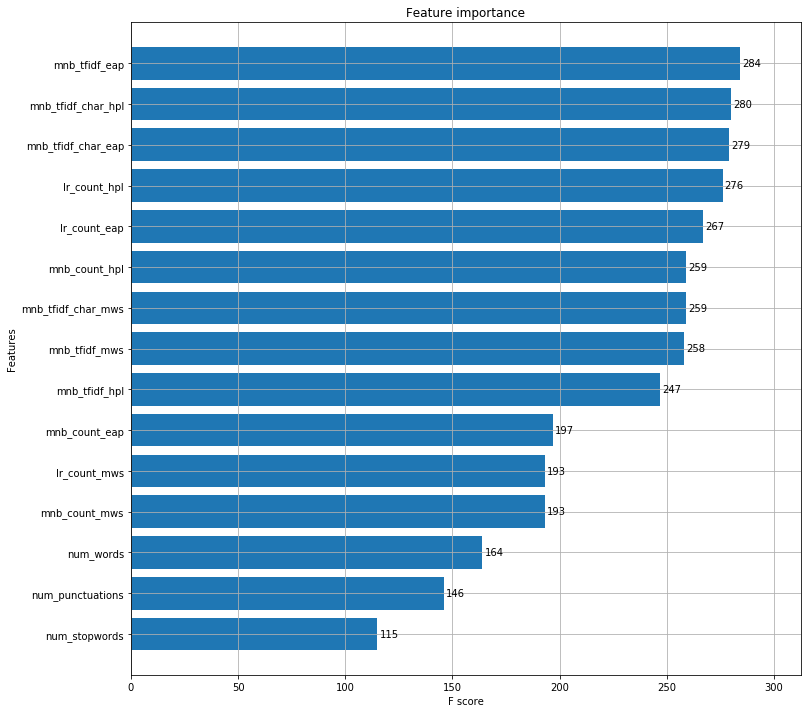

In [42]:
### Run XGboost on features so far ###

# Drop the necessary columns
def run_xgb_preprocess(x_train, x_test, params):
    
    features_drop = params['features_drop']
    
    # train data
    drop_columns_train = ['id','text','author']
    if features_drop is not None:
        drop_columns_train = drop_columns_train + features_drop
    x_train_features = x_train.drop(drop_columns_train, axis=1)
        
    # test data
    drop_columns_test = ['id','text']
    if features_drop is not None:
        drop_columns_test = drop_columns_test + features_drop
    x_test_features = x_test.drop(drop_columns_test, axis = 1)    
    
    return x_train_features, x_test_features, None

#####################
## XGboost:
#####################
def run_xgb(train_X, train_y, 
                      val_X, val_y, 
                      test_X, 
                      model_params):
    
    # Extra params
    seed_val = model_params['seed_val']
    child = model_params['child']
    colsample = model_params['colsample']
    
    # Params list
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    early_stopping_rounds = 50
    num_rounds = 2000
    param_list = list(param.items())
   
    # Train 
    d_train = xgb.DMatrix(train_X, label= train_y)
    d_val = xgb.DMatrix(val_X, label= val_y)
    watchlist = [ (d_train,'train'), (d_val, 'cross-valid') ]
    model = xgb.train(param_list, d_train, num_rounds, 
                      watchlist, early_stopping_rounds= early_stopping_rounds, 
                      verbose_eval=20)
    
    # Get validation predictions 
    #pred_train = model.predict(d_train, 
    #                            ntree_limit = model.best_ntree_limit)
    pred_val = model.predict(d_val, 
                                ntree_limit = model.best_ntree_limit)
    
    # Get test set predictions.
    d_test = xgb.DMatrix(test_X)
    pred_test = model.predict(d_test, 
                                 ntree_limit = model.best_ntree_limit)

    return pred_val, pred_test, model

# Run XGboost and add predictions as features:
model_name = "xgboost_stacking_1"
model_preprocess_function = run_xgb_preprocess
model_function = run_xgb
model_params = {'seed_val': 0, 'child': 1, 'colsample': 0.3 }
#features_drop = ['num_punctuations','num_stopwords','num_words']
features_drop = None
model_preprocess_params = {'features_drop': features_drop }
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "VECT", 
                                           train_raw, y_train_raw, test_raw, 0) 
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

### Cell used for initial training to search for good models and hyperparameters: - Disabled now

 - Split the data into training and test set
 - Tokenize the input and try Count vectorizer, Tf-idf vectorizer
 - Try MNB, LR and GridSearchCV for hyperparameters.
 - Try Stemming + Lemmatize, with / without stopwords, various n-grams for Tf-idf etc.

### Word embeddings + Neural networks / Deep learning

In [43]:
# Convert labels to one hot to train NN
y_train_one_hot = to_categorical(y_train)
print(y_train_one_hot.shape)
print(y_train[0], y_train_one_hot[0])

(19579, 3)
0 [ 1.  0.  0.]


#### The following cells are used for pre-processing text for NN networks

In [44]:
###################################
# Function to create word2vec from 
# given texts using gensim
###################################

def create_gensim_wordvec(x_train, wordvecsize):
    
    from gensim.models import Word2Vec
    from gensim.utils import simple_preprocess
    
    ngrams_max = 2
    sentences = []
    for sent in x_train:
        simple = 0
        if simple:
            # only tokenize
            #print(sent)
            sent_temp = simple_preprocess(sent)
            sentences.append(sent_temp)
            #print(sent_temp)
            #break
        else:
            # separate punctuation
            sent = sent.replace("' ", " ' ")
            punct = set('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~')
            prods = set(sent) & punct
            #print("sent is {}".format(sent))
            ##print("punct is {}".format(punct))
            #print("prods is {}".format(prods))
            if not prods:
                continue
            for sign in prods:
                sent = sent.replace(sign, ' {} '.format(sign))
            #sent = sent.split()
            
            # Add n-grams
            sent_words = sent.split()
            ngrams = []
            for nidx in range(2, ngrams_max+1):
                for widx in range(len(sent_words) - nidx + 1):                    
                    ngrams.append('--'.join(sent_words[widx:widx+nidx]))
                    #break
            ngrams_string = ' '.join(ngrams)
            sent = sent + ' ' + ngrams_string
            sent = sent.split()
            sentences.append(sent)
            #print(sent)
            #break
            
    print(sentences[0:2])
    wordvecsize = wordvecsize
    gensim_model = Word2Vec(sentences, 
                            window=5, iter=25, size=wordvecsize, min_count=2)

    # Get some details
    print(gensim_model)
    # Get the most and least common words
    vocab_size_gensim = len(gensim_model.wv.vocab)
    print(vocab_size_gensim)
    print(gensim_model.wv.index2word[0], 
          gensim_model.wv.index2word[1], 
          gensim_model.wv.index2word[2])
    print(gensim_model.wv.index2word[vocab_size_gensim - 1], 
          gensim_model.wv.index2word[vocab_size_gensim - 2], 
          gensim_model.wv.index2word[vocab_size_gensim - 3])
    print('Index of "of" is: {}'.format(gensim_model.wv.vocab['of'].index))
    print(gensim_model.wv['the'])

    # Write out vectors file
    #weights = gensim_model.syn0 
    gensim_embeddings = '../scratch/gensim.'+ str(wordvecsize) +'.txt'
    word_vectors = gensim_model.wv
    word_vectors.save(gensim_embeddings)
    print(len(gensim_model.wv.vocab.keys()))
    f = open(gensim_embeddings, 'w')
    for w in gensim_model.wv.vocab.keys():
        v = gensim_model.wv[w]
        #print("{} {}".format(w,v))
        f.write("{} ".format(w))
        for vi in v:
            #print("{} ".format(vi))
            f.write("{} ".format(vi))
        #break
        f.write("\n")
    f.close()

# Disabled here
if False:
    ###################################
    # Create gensim wordvectors from given text 
    ###################################
    create_gensim_wordvectors = 1
    if create_gensim_wordvectors:
        wordvecsize = 20
        create_gensim_wordvec(X_train, wordvecsize)

In [45]:
######################################################
# Function to Preprocess to separate out punctuation and n-grams 
# since Tokenizer isnt doing good.
#######################################################
def preprocess(x_train):
    
    idx = 0
    separate_punctuation = True
    # Fast text: ngrams_max = 2
    ngrams_max = 2
    for sent in x_train:
        #print(type(sent))

        if separate_punctuation:
            # Separate punctuation
            sent = sent.replace("' ", " ' ")
            punct = set('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~')
            prods = set(sent) & punct
            #print("sent is {}".format(sent))
            ##print("punct is {}".format(punct))
            #print("prods is {}".format(prods))
            if not prods:
                continue
            for sign in prods:
                sent = sent.replace(sign, ' {} '.format(sign))
            #print("new sent is {}".format(sent))
            x_train.iloc[idx] = sent

        if False:
            # Remove punctuation before ngrams
            sent = sent.replace("' ", " ' ")
            punct = set('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~')
            prods = set(sent) & punct
            #print("sent is {}".format(sent))
            ##print("punct is {}".format(punct))
            #print("prods is {}".format(prods))
            if not prods:
                continue
            for sign in prods:
                sent = sent.replace(sign,''.format(sign))
            #print("new sent is {}".format(sent))
            x_train.iloc[idx] = sent
            
        if ngrams_max > 1:
            # Add n-grams
            sent_words = sent.split()
            ngrams = []
            for nidx in range(2, ngrams_max+1):
                for widx in range(len(sent_words) - nidx + 1):                    
                    ngrams.append('--'.join(sent_words[widx:widx+nidx]))
                    #break
            ngrams_string = ' '.join(ngrams)
            sent = sent + ' ' + ngrams_string
            #print("new sent is {}".format(sent))
            x_train.iloc[idx] = sent

        idx += 1
        #break
        
    return x_train

# Disabled code
if False:
    ###################################
    # Preprocess X_train and X_test data:
    # Separate punctuation, add ngrams
    ###################################
    x_train = preprocess(X_train)
    print(x_train.head())
    print(x_train.iloc[0])
    x_test = preprocess(X_test)
    print(x_test.head())
    print(x_test.iloc[0])
    #print(X_train_orig.head())

In [46]:
## Convert text to integers that can be input to Embedding layer

def create_tokenizer(X_train, char_level):
    
    # This is for word vectors to be learnt by embedding layer
    if char_level:
        tokenizer = Tokenizer(filters='', char_level = True)
        #tokenizer = Tokenizer()
    else:
        tokenizer = Tokenizer(filters='')

    tokenizer.fit_on_texts(X_train)
    vocab_size = len(tokenizer.word_index) + 1
    sentences_encoded = tokenizer.texts_to_sequences(X_train) 
    print("No of unique words found is " + str(vocab_size))

    min_num_occ = 2
    num_words_atleastocc = sum([1 for w,c in tokenizer.word_counts.items() if c >= min_num_occ])
    print("No of words occuring more than %d times is %d" % (min_num_occ, num_words_atleastocc))
    # hardcode to 10000
    #num_words_atleastocc = 15000
    tokenizer = Tokenizer(num_words=num_words_atleastocc,filters='')
    tokenizer.fit_on_texts(X_train)
    vocab_size = len(tokenizer.word_index) + 1
    sentences_encoded = tokenizer.texts_to_sequences(X_train) 
    print("No of unique words found is after capping is " + str(vocab_size))

    # Cap the length of sentence, and pad with 0 if sentences less than that length
    sent_lengths = [len(s) for s in sentences_encoded]
    sent_lengths_arr = np.array(sent_lengths)
    print("max sentence length is {}".format(len(max(sentences_encoded, key = len))))
    print("mean, median, 99th perc length of sentence is %f %f %f" % (
        np.mean(sent_lengths_arr),np.median(sent_lengths_arr),
        np.percentile(sent_lengths_arr,99)))
    #plt.figure()
    #sns.violinplot(y=np.array(sent_lengths))
    # Fasttext: sentence_maxlength_cap = 256
    sentence_maxlength_cap = int(np.percentile(sent_lengths_arr,99))
    #sentence_maxlength_cap = 140
    sentences_encoded = pad_sequences(sentences_encoded, maxlen=sentence_maxlength_cap)
    print("After padding: max sentence size is {}".format(len(max(sentences_encoded, key = len))))
    sent_lengths = [len(s) for s in sentences_encoded]
    print("After padding: mean, median length of sentence is %f %f" % (np.mean(np.array(sent_lengths)),np.median(np.array(sent_lengths))))

    # dimension of word vector output from Embedding layer
    # Fasttext: wordvecdim = 20
    wordvecdim = 20
    
    return  wordvecdim, sentence_maxlength_cap, sentences_encoded, tokenizer, vocab_size

# Disabled code
if False:
    # Create tokenizer and encoded sentences X_train:
    #wordvecdim, sentence_maxlength_cap, sentences_encoded, tokenizer, vocab_size = create_tokenizer(x_train, 0)
    (wordvecdim, sentence_maxlength_cap, 
     sentences_encoded, tokenizer, vocab_size) = create_tokenizer(x_train, 0)

    ### debug ###
    if True:
        print(X_train.head())
        #print(tokenizer.word_index)
        firstfewwords = {k: tokenizer.word_index[k] for k in list(tokenizer.word_index)[0:5]}
        print("first few words are", firstfewwords)
        print(sentences_encoded[0])
        print(tokenizer.document_count)
        print(len(sentences_encoded))
        print(y_train.shape)
        print(len(tokenizer.word_counts.keys()))  
        print(list(tokenizer.word_index)[:100])  

In [47]:
# Create word embedding matrix for word vectors:
def create_word_embedding_matrix(word_vector_type, vocab_size, tokenizer):
    
    if word_vector_type == "None":
        print("")
        return None
    
    print("Creating word embedding matrix for {} vectors".format(word_vector_type))
    
    if word_vector_type == "glove": 
        # Load pre-trained Glove vectors. 
        # Convert them as word to word vector mapping
        # https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
        wordvecdim = 100
        f = open('../scratch/glove.6B.100d.txt')

    if word_vector_type == "gensim":
        wordvecdim = 20
        gensim_embeddings = '../scratch/gensim.'+ str(wordvecdim) +'.txt'
        f = open(gensim_embeddings)


    embeddings_index = {}
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))


    # Create pretrained weight matrix to be used as Embedded layer input 
    # Each word (in input data) to its pretrained word vector mapping
    embedding_matrix = np.zeros((vocab_size,wordvecdim))
    for word, idx in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            embedding_matrix[idx] = np.zeros(wordvecdim)
            #break
    print(word,idx)
    print(embedding_vector)
    print(embedding_matrix.shape)
    
    return wordvecdim, embedding_matrix

# Disabled code:
if False:
    gs_wordvecdim, gs_embedding_matrix = create_word_embedding_matrix("gensim", vocab_size)
    gl_wordvecdim, gl_embedding_matrix = create_word_embedding_matrix("glove", vocab_size)

### Cell used for tuning hyper-parameters - Disabled now

### Pre-processing for NN - top level function

In [48]:
# Preprocessing (top level function) needed for Neural networks

def run_NN_preprocess(X_train, X_test, params):    
    
    # Make a copy
    X_train = train_raw['text'].copy()
    X_test = test_raw['text'].copy()
    
    # Preprocess X_train and X_test data: Separate punctuation, add ngrams
    x_train = preprocess(X_train)
    #print(x_train.head())
    #print(x_train.iloc[0])
    x_test = preprocess(X_test)
    #print(x_test.head())
    #print(x_test.iloc[0])
    
    # Word vector type:
    word_vector_type = params['word_vector_type']
    
    # Char level tokenize
    char_level_tokenize = params['char_level']
    
    # Create tokenizer and encoded sentences:
    (wordvecdim, sentence_maxlength_cap, 
     sentences_encoded_train, tokenizer, vocab_size) = create_tokenizer(x_train, 0)
    # For debug 
    if False:
        print(X_train.head())
        #print(tokenizer.word_index)
        firstfewwords = {k: tokenizer.word_index[k] for k in list(tokenizer.word_index)[0:5]}
        print("first few words are", firstfewwords)
        print(sentences_encoded_train[0])
        print(tokenizer.document_count)
        print(len(sentences_encoded_train))
        print(y_train.shape)
        print(len(tokenizer.word_counts.keys()))  
        print(list(tokenizer.word_index)[:100]) 
    
    # Create encoded sentences for test set:
    sentences_encoded_test = tokenizer.texts_to_sequences(x_test) 
    sentences_encoded_test = pad_sequences(sentences_encoded_test, 
                                            maxlen=sentence_maxlength_cap)    
    
    # Create word2vec using gensim:
    if word_vector_type is not None:
        wordvecdim, embedding_matrix = create_word_embedding_matrix(word_vector_type, 
                                                                      vocab_size,
                                                                      tokenizer)
    else:
        embedding_matrix = None
        
    # Store the output params
    out_params = {'vocab_size': vocab_size,
                 'wordvecdim': wordvecdim,
                 'sentence_maxlength_cap': sentence_maxlength_cap,
                 'embedding_matrix': embedding_matrix,
                 'word_vector_type': word_vector_type,
                 'tokenizer': tokenizer}
    
    return sentences_encoded_train, sentences_encoded_test, out_params
    

### FastText model definition and running:

In [49]:
# Fast text model 

def run_Fasttext(sentences_encoded_train, y_train_one_hot,
                 sentences_encoded_val, y_val_one_hot,
                 sentences_encoded_test, 
                 model_params):  

    # All model params
    vocab_size = model_params['vocab_size'] 
    wordvecdim = model_params['wordvecdim']
    sentence_maxlength_cap = model_params['sentence_maxlength_cap']
    embedding_matrix = model_params['embedding_matrix']
    word_vector_type = model_params['word_vector_type']
    tokenizer =  model_params['tokenizer']    
    print("Creating Fasttext model vocab_size: {}, wordvecdim {}, sentence_maxlength_cap {}, word_vector_type {} ".format( 
          vocab_size, wordvecdim, sentence_maxlength_cap, word_vector_type))
    
    # Train the Fasttext NN model (1 hidden layer)
    model = Sequential()
    if word_vector_type == "glove":
        embedded_layer = Embedding(vocab_size, wordvecdim, 
                                   input_length = sentence_maxlength_cap, 
                                   weights = [embedding_matrix], trainable = False)
        #embedded_layer = Embedding(vocab_size, wordvecdim, input_length = sentence_maxlength_cap, weights = [embedding_matrix], trainable = True)
    elif word_vector_type == "gensim":
        embedded_layer = Embedding(vocab_size, wordvecdim, 
                                   input_length = sentence_maxlength_cap, 
                                   weights = [embedding_matrix], trainable = True)
    else:
        embedded_layer = Embedding(vocab_size, wordvecdim, 
                                   input_length = sentence_maxlength_cap)
    model.add(embedded_layer)
    #model.add(Flatten())
    #model.add(Dense(20,activation='relu'))
    #model.add(Conv1D(filters = 8, kernel_size = 5,activation='relu'))
    #model.add(MaxPooling1D(pool_size=10))
    #model.add(Dropout(0.75))
    #model.add(Flatten())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(3,activation='softmax'))
    model.summary()

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Pre training loss
    loss, score = model.evaluate(sentences_encoded_train, y_train_one_hot)
    print("Before training loss, score are: {} {}".format(loss,score))

    # Fit the model to train data
    #num_epochs = 200
    num_epochs = 150
    validation_data = (sentences_encoded_val, y_val_one_hot)
    checkpointer = EarlyStopping(patience=3, monitor='val_loss')
    model.fit(sentences_encoded_train, y_train_one_hot,
              epochs= num_epochs, 
              batch_size=128, 
              verbose=1, 
              validation_data = validation_data,
              #validation_split = 0.05, shuffle = True,              
              callbacks=[checkpointer])

    # Training loss and predictions:
    loss, score = model.evaluate(sentences_encoded_train, y_train_one_hot)
    print("==== Training loss, score are: {} {} =======".format(loss,score))
    pred_train = model.predict(sentences_encoded_train)

    # Val loss and predictions:
    loss, score = model.evaluate(sentences_encoded_val, y_val_one_hot)
    print("==== CV loss, score are: {} {} =======".format(loss,score))
    pred_val = model.predict(sentences_encoded_val)
    
    # Test loss and predictions:
    pred_test = model.predict(sentences_encoded_test)

    return pred_val, pred_test, model

In [50]:
# Run Fast text and add predictions as features:

# No pre-trained vectors:
print('Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()))
model_name = "fast_text_none"
model_preprocess_function = run_NN_preprocess
model_function = run_Fasttext
model_params = {'temp': 0 }
model_preprocess_params = {'char_level': 0, 'word_vector_type': None }
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "NN", 
                                           train_raw, y_train_one_hot, test_raw, 1) 
train_raw, test_raw = add_pred_features(model_name, 
                                        train_raw, test_raw, 
                                        pred_train, pred_test)

# Pre-trained word2vec using vectors:
print('Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()))
wordvecsize = 20
create_gensim_wordvectors = 0
if create_gensim_wordvectors:
    create_gensim_wordvec(train_raw['text'], wordvecsize)
model_name = "fast_text_gensim"
model_preprocess_function = run_NN_preprocess
model_function = run_Fasttext
model_params = {'temp': 0 }
model_preprocess_params = {'char_level': 0, 'word_vector_type': "gensim" }
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "NN", 
                                           train_raw, y_train_one_hot, test_raw, 1) 
train_raw, test_raw = add_pred_features(model_name, 
                                        train_raw, test_raw, 
                                        pred_train, pred_test)
    
# Glove vectors:
print('Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()))
model_name = "fast_text_glove"
model_preprocess_function = run_NN_preprocess
model_function = run_Fasttext
model_params = {'temp': 0 }
model_preprocess_params = {'char_level': 0, 'word_vector_type': "glove" }
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "NN", 
                                           train_raw, y_train_one_hot, test_raw, 1) 
train_raw, test_raw = add_pred_features(model_name, 
                                        train_raw, test_raw, 
                                        pred_train, pred_test)


Timestamp: 2018-Jan-14 02:51:50
Running kfold training with model fast_text_none
Shapes: x_train_raw.shape (19579, 18), y_train_raw.shape (19579, 3) , x_test_raw.shape (8392, 17)
Running preprocess: <function run_NN_preprocess at 0x7f620ee8eea0>
No of unique words found is 247346
No of words occuring more than 2 times is 75104
No of unique words found is after capping is 247346
max sentence length is 1439
mean, median, 99th perc length of sentence is 50.867358 44.000000 161.000000
After padding: max sentence size is 161
After padding: mean, median length of sentence is 161.000000 161.000000
Shapes: x_train.shape (19579, 161), y_train.shape (19579, 3) , x_test.shape (8392, 161)
Running fold 1
Creating Fasttext model vocab_size: 247346, wordvecdim 20, sentence_maxlength_cap 161, word_vector_type None 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 161, 20)           49

Epoch 49/150
15663/15663 [==============================] - 1s 46us/step - loss: 0.0451 - acc: 0.9959 - val_loss: 0.3493 - val_acc: 0.8616
Epoch 50/150
15663/15663 [==============================] - 1s 47us/step - loss: 0.0427 - acc: 0.9962 - val_loss: 0.3494 - val_acc: 0.8639
Epoch 51/150
15663/15663 [==============================] - 0s 21us/step
==== Training loss, score are: 0.038422147226279964 0.9968077635191215 =======
3916/3916 [==============================] - 0s 21us/step
==== CV loss, score are: 0.34937799246306317 0.8636363636363636 =======
Running fold 3
Creating Fasttext model vocab_size: 247346, wordvecdim 20, sentence_maxlength_cap 161, word_vector_type None 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 161, 20)           4946920   
_________________________________________________________________
global_average_pooling1d_6 ( (None, 20)            

15663/15663 [==============================] - 1s 46us/step - loss: 0.0627 - acc: 0.9936 - val_loss: 0.3420 - val_acc: 0.8664
Epoch 45/150
15663/15663 [==============================] - 1s 47us/step - loss: 0.0596 - acc: 0.9941 - val_loss: 0.3410 - val_acc: 0.8685
Epoch 46/150
15663/15663 [==============================] - 1s 46us/step - loss: 0.0560 - acc: 0.9948 - val_loss: 0.3402 - val_acc: 0.8685
Epoch 47/150
15663/15663 [==============================] - 1s 46us/step - loss: 0.0531 - acc: 0.9948 - val_loss: 0.3394 - val_acc: 0.8687
Epoch 48/150
15663/15663 [==============================] - 1s 45us/step - loss: 0.0501 - acc: 0.9957 - val_loss: 0.3399 - val_acc: 0.8659
Epoch 49/150
15663/15663 [==============================] - 1s 46us/step - loss: 0.0474 - acc: 0.9957 - val_loss: 0.3386 - val_acc: 0.8690
Epoch 50/150
15663/15663 [==============================] - 1s 45us/step - loss: 0.0449 - acc: 0.9960 - val_loss: 0.3384 - val_acc: 0.8682
Epoch 51/150
15663/15663 [==============

9584it [00:00, 95826.61it/s]

Creating word embedding matrix for gensim vectors


76597it [00:00, 96042.27it/s]


Found 76597 word vectors.
of--mirth 247345
None
(247346, 20)
Shapes: x_train.shape (19579, 161), y_train.shape (19579, 3) , x_test.shape (8392, 161)
Running fold 1
Creating Fasttext model vocab_size: 247346, wordvecdim 20, sentence_maxlength_cap 161, word_vector_type gensim 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 161, 20)           4946920   
_________________________________________________________________
global_average_pooling1d_9 ( (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 63        
Total params: 4,946,983
Trainable params: 4,946,983
Non-trainable params: 0
_________________________________________________________________
15663/15663 [==============================] - 0s 29us/step
Before training loss, score are: 1.1140749234772045 0.334035

15663/15663 [==============================] - 1s 46us/step - loss: 0.2780 - acc: 0.9351 - val_loss: 0.4808 - val_acc: 0.8195
Epoch 33/150
15663/15663 [==============================] - 1s 46us/step - loss: 0.2655 - acc: 0.9386 - val_loss: 0.4733 - val_acc: 0.8195
Epoch 34/150
15663/15663 [==============================] - 1s 45us/step - loss: 0.2534 - acc: 0.9427 - val_loss: 0.4669 - val_acc: 0.8233
Epoch 35/150
15663/15663 [==============================] - 1s 44us/step - loss: 0.2421 - acc: 0.9467 - val_loss: 0.4605 - val_acc: 0.8228
Epoch 36/150
15663/15663 [==============================] - 1s 44us/step - loss: 0.2309 - acc: 0.9504 - val_loss: 0.4548 - val_acc: 0.8246
Epoch 37/150
15663/15663 [==============================] - 1s 46us/step - loss: 0.2205 - acc: 0.9528 - val_loss: 0.4489 - val_acc: 0.8266
Epoch 38/150
15663/15663 [==============================] - 1s 45us/step - loss: 0.2106 - acc: 0.9549 - val_loss: 0.4436 - val_acc: 0.8297
Epoch 39/150
15663/15663 [==============

15663/15663 [==============================] - 1s 44us/step - loss: 0.0533 - acc: 0.9927 - val_loss: 0.3544 - val_acc: 0.8649
Epoch 69/150
15663/15663 [==============================] - 1s 44us/step - loss: 0.0510 - acc: 0.9928 - val_loss: 0.3549 - val_acc: 0.8639
Epoch 70/150
15663/15663 [==============================] - 1s 45us/step - loss: 0.0487 - acc: 0.9936 - val_loss: 0.3543 - val_acc: 0.8649
Epoch 71/150
15663/15663 [==============================] - 1s 45us/step - loss: 0.0465 - acc: 0.9947 - val_loss: 0.3553 - val_acc: 0.8649
Epoch 72/150
15663/15663 [==============================] - 1s 44us/step - loss: 0.0445 - acc: 0.9946 - val_loss: 0.3545 - val_acc: 0.8636
Epoch 73/150
15663/15663 [==============================] - 1s 44us/step - loss: 0.0426 - acc: 0.9951 - val_loss: 0.3540 - val_acc: 0.8672
Epoch 74/150
15663/15663 [==============================] - 1s 44us/step - loss: 0.0407 - acc: 0.9953 - val_loss: 0.3535 - val_acc: 0.8636
Epoch 75/150
15663/15663 [==============

Epoch 14/150
15664/15664 [==============================] - 1s 47us/step - loss: 0.6558 - acc: 0.7866 - val_loss: 0.7016 - val_acc: 0.7436
Epoch 15/150
15664/15664 [==============================] - 1s 45us/step - loss: 0.6257 - acc: 0.7993 - val_loss: 0.6792 - val_acc: 0.7533
Epoch 16/150
15664/15664 [==============================] - 1s 45us/step - loss: 0.5966 - acc: 0.8128 - val_loss: 0.6590 - val_acc: 0.7596
Epoch 17/150
15664/15664 [==============================] - 1s 46us/step - loss: 0.5695 - acc: 0.8228 - val_loss: 0.6410 - val_acc: 0.7699
Epoch 18/150
15664/15664 [==============================] - 1s 47us/step - loss: 0.5429 - acc: 0.8325 - val_loss: 0.6237 - val_acc: 0.7752
Epoch 19/150
15664/15664 [==============================] - 1s 48us/step - loss: 0.5177 - acc: 0.8442 - val_loss: 0.6059 - val_acc: 0.7808
Epoch 20/150
15664/15664 [==============================] - 1s 46us/step - loss: 0.4939 - acc: 0.8528 - val_loss: 0.5906 - val_acc: 0.7844
Epoch 21/150
15664/15664 [=

3915/3915 [==============================] - 0s 22us/step
==== CV loss, score are: 0.35661753699240556 0.8587484035607651 =======


===== Model: fast_text_gensim  ========:
 Cross-val log losses are: [0.38271956085864439, 0.378870709472864, 0.35414783893485785, 0.35920845544401081, 0.35661753207869984]
====== Mean cross-val log loss is: 0.3663128193578154 =========


Timestamp: 2018-Jan-14 02:59:52
Running kfold training with model fast_text_glove
Shapes: x_train_raw.shape (19579, 24), y_train_raw.shape (19579, 3) , x_test_raw.shape (8392, 23)
Running preprocess: <function run_NN_preprocess at 0x7f620ee8eea0>
No of unique words found is 247346
No of words occuring more than 2 times is 75104
No of unique words found is after capping is 247346
max sentence length is 1439
mean, median, 99th perc length of sentence is 50.867358 44.000000 161.000000
After padding: max sentence size is 161
After padding: mean, median length of sentence is 161.000000 161.000000


5007it [00:00, 50060.98it/s]

Creating word embedding matrix for glove vectors


400000it [00:08, 49133.71it/s]


Found 400000 word vectors.
of--mirth 247345
None
(247346, 100)
Shapes: x_train.shape (19579, 161), y_train.shape (19579, 3) , x_test.shape (8392, 161)
Running fold 1
Creating Fasttext model vocab_size: 247346, wordvecdim 100, sentence_maxlength_cap 161, word_vector_type glove 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 161, 100)          24734600  
_________________________________________________________________
global_average_pooling1d_14  (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 303       
Total params: 24,734,903
Trainable params: 303
Non-trainable params: 24,734,600
_________________________________________________________________
15663/15663 [==============================] - 1s 37us/step
Before training loss, score are: 1.0987276865864732 0.

Epoch 110/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8270 - acc: 0.6397 - val_loss: 0.8306 - val_acc: 0.6438
Epoch 111/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8265 - acc: 0.6400 - val_loss: 0.8299 - val_acc: 0.6461
Epoch 112/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8260 - acc: 0.6412 - val_loss: 0.8297 - val_acc: 0.6448
Epoch 113/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8256 - acc: 0.6407 - val_loss: 0.8293 - val_acc: 0.6461
Epoch 114/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8250 - acc: 0.6409 - val_loss: 0.8287 - val_acc: 0.6461
Epoch 115/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8245 - acc: 0.6409 - val_loss: 0.8280 - val_acc: 0.6463
Epoch 116/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8240 - acc: 0.6418 - val_loss: 0.8277 - val_acc: 0.6463
Epoch 117/150
15663/

15663/15663 [==============================] - 0s 15us/step - loss: 0.8564 - acc: 0.6291 - val_loss: 0.8667 - val_acc: 0.6193
Epoch 69/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8553 - acc: 0.6283 - val_loss: 0.8662 - val_acc: 0.6177
Epoch 70/150
15663/15663 [==============================] - 0s 15us/step - loss: 0.8543 - acc: 0.6287 - val_loss: 0.8646 - val_acc: 0.6162
Epoch 71/150
15663/15663 [==============================] - 0s 15us/step - loss: 0.8533 - acc: 0.6298 - val_loss: 0.8634 - val_acc: 0.6198
Epoch 72/150
15663/15663 [==============================] - 0s 15us/step - loss: 0.8523 - acc: 0.6295 - val_loss: 0.8625 - val_acc: 0.6203
Epoch 73/150
15663/15663 [==============================] - 0s 15us/step - loss: 0.8512 - acc: 0.6319 - val_loss: 0.8628 - val_acc: 0.6185
Epoch 74/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8504 - acc: 0.6302 - val_loss: 0.8616 - val_acc: 0.6195
Epoch 75/150
15663/15663 [==============

Epoch 127/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8177 - acc: 0.6469 - val_loss: 0.8314 - val_acc: 0.6282
Epoch 128/150
15663/15663 [==============================] - 0s 18us/step - loss: 0.8173 - acc: 0.6480 - val_loss: 0.8304 - val_acc: 0.6295
Epoch 129/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8168 - acc: 0.6476 - val_loss: 0.8300 - val_acc: 0.6310
Epoch 130/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8164 - acc: 0.6477 - val_loss: 0.8295 - val_acc: 0.6323
Epoch 131/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8160 - acc: 0.6485 - val_loss: 0.8302 - val_acc: 0.6284
Epoch 132/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8157 - acc: 0.6484 - val_loss: 0.8289 - val_acc: 0.6302
Epoch 133/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8153 - acc: 0.6462 - val_loss: 0.8283 - val_acc: 0.6315
Epoch 134/150
15663/

15663/15663 [==============================] - 0s 14us/step - loss: 0.8421 - acc: 0.6366 - val_loss: 0.8490 - val_acc: 0.6195
Epoch 86/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8412 - acc: 0.6369 - val_loss: 0.8483 - val_acc: 0.6259
Epoch 87/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8405 - acc: 0.6377 - val_loss: 0.8479 - val_acc: 0.6200
Epoch 88/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8398 - acc: 0.6384 - val_loss: 0.8470 - val_acc: 0.6228
Epoch 89/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8390 - acc: 0.6392 - val_loss: 0.8464 - val_acc: 0.6261
Epoch 90/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8383 - acc: 0.6386 - val_loss: 0.8456 - val_acc: 0.6241
Epoch 91/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8376 - acc: 0.6383 - val_loss: 0.8451 - val_acc: 0.6246
Epoch 92/150
15663/15663 [==============

Epoch 144/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8119 - acc: 0.6499 - val_loss: 0.8225 - val_acc: 0.6300
Epoch 145/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8117 - acc: 0.6501 - val_loss: 0.8225 - val_acc: 0.6300
Epoch 146/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8113 - acc: 0.6491 - val_loss: 0.8218 - val_acc: 0.6292
Epoch 147/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8109 - acc: 0.6497 - val_loss: 0.8220 - val_acc: 0.6302
Epoch 148/150
15663/15663 [==============================] - 0s 15us/step - loss: 0.8108 - acc: 0.6501 - val_loss: 0.8213 - val_acc: 0.6292
Epoch 149/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8103 - acc: 0.6505 - val_loss: 0.8211 - val_acc: 0.6297
Epoch 150/150
15663/15663 [==============================] - 0s 22us/step
==== Training loss, score are: 0.8096670357460858 0.6505777948296771 =======
3916/3916

15663/15663 [==============================] - 0s 15us/step - loss: 0.8330 - acc: 0.6380 - val_loss: 0.8294 - val_acc: 0.6427
Epoch 103/150
15663/15663 [==============================] - 0s 15us/step - loss: 0.8324 - acc: 0.6372 - val_loss: 0.8292 - val_acc: 0.6417
Epoch 104/150
15663/15663 [==============================] - 0s 15us/step - loss: 0.8318 - acc: 0.6379 - val_loss: 0.8283 - val_acc: 0.6422
Epoch 105/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8313 - acc: 0.6376 - val_loss: 0.8276 - val_acc: 0.6440
Epoch 106/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8308 - acc: 0.6377 - val_loss: 0.8274 - val_acc: 0.6435
Epoch 107/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8302 - acc: 0.6381 - val_loss: 0.8268 - val_acc: 0.6433
Epoch 108/150
15663/15663 [==============================] - 0s 14us/step - loss: 0.8297 - acc: 0.6372 - val_loss: 0.8264 - val_acc: 0.6443
Epoch 109/150
15663/15663 [=======

15664/15664 [==============================] - 0s 14us/step - loss: 0.8684 - acc: 0.6217 - val_loss: 0.8625 - val_acc: 0.6314
Epoch 61/150
15664/15664 [==============================] - 0s 16us/step - loss: 0.8674 - acc: 0.6216 - val_loss: 0.8616 - val_acc: 0.6350
Epoch 62/150
15664/15664 [==============================] - 0s 15us/step - loss: 0.8660 - acc: 0.6216 - val_loss: 0.8597 - val_acc: 0.6319
Epoch 63/150
15664/15664 [==============================] - 0s 15us/step - loss: 0.8649 - acc: 0.6223 - val_loss: 0.8590 - val_acc: 0.6350
Epoch 64/150
15664/15664 [==============================] - 0s 14us/step - loss: 0.8637 - acc: 0.6231 - val_loss: 0.8582 - val_acc: 0.6360
Epoch 65/150
15664/15664 [==============================] - 0s 14us/step - loss: 0.8626 - acc: 0.6250 - val_loss: 0.8566 - val_acc: 0.6350
Epoch 66/150
15664/15664 [==============================] - 0s 14us/step - loss: 0.8614 - acc: 0.6249 - val_loss: 0.8553 - val_acc: 0.6342
Epoch 67/150
15664/15664 [==============

Epoch 119/150
15664/15664 [==============================] - 0s 14us/step - loss: 0.8245 - acc: 0.6393 - val_loss: 0.8207 - val_acc: 0.6549
Epoch 120/150
15664/15664 [==============================] - 0s 14us/step - loss: 0.8240 - acc: 0.6410 - val_loss: 0.8198 - val_acc: 0.6544
Epoch 121/150
15664/15664 [==============================] - 0s 14us/step - loss: 0.8235 - acc: 0.6410 - val_loss: 0.8192 - val_acc: 0.6559
Epoch 122/150
15664/15664 [==============================] - 0s 14us/step - loss: 0.8231 - acc: 0.6415 - val_loss: 0.8185 - val_acc: 0.6549
Epoch 123/150
15664/15664 [==============================] - 0s 14us/step - loss: 0.8228 - acc: 0.6418 - val_loss: 0.8183 - val_acc: 0.6557
Epoch 124/150
15664/15664 [==============================] - 0s 14us/step - loss: 0.8223 - acc: 0.6410 - val_loss: 0.8185 - val_acc: 0.6552
Epoch 125/150
15664/15664 [==============================] - 0s 14us/step - loss: 0.8218 - acc: 0.6424 - val_loss: 0.8174 - val_acc: 0.6554
Epoch 126/150
15664/

### CNN model definition and running:

In [51]:
# CNN 
def run_CNN(sentences_encoded_train, y_train_one_hot,
                 sentences_encoded_val, y_val_one_hot,
                 sentences_encoded_test, 
                 model_params):  

    # All model params
    vocab_size = model_params['vocab_size'] 
    wordvecdim = model_params['wordvecdim']
    sentence_maxlength_cap = model_params['sentence_maxlength_cap']
    embedding_matrix = model_params['embedding_matrix']
    word_vector_type = model_params['word_vector_type']
    tokenizer =  model_params['tokenizer']    
    print("Creating CNN model vocab_size: {}, wordvecdim {}, sentence_maxlength_cap {}, word_vector_type {} ".format( 
          vocab_size, wordvecdim, sentence_maxlength_cap, word_vector_type))
    
    # Train CNN model (1 hidden layer)
    model = Sequential()
    if word_vector_type == "glove":
        embedded_layer = Embedding(vocab_size, wordvecdim, 
                                   input_length = sentence_maxlength_cap, 
                                   weights = [embedding_matrix], trainable = False)
        #embedded_layer = Embedding(vocab_size, wordvecdim, input_length = sentence_maxlength_cap, weights = [embedding_matrix], trainable = True)
    elif word_vector_type == "gensim":
        embedded_layer = Embedding(vocab_size, wordvecdim, 
                                   input_length = sentence_maxlength_cap, 
                                   weights = [embedding_matrix], trainable = True)
    else:
        embedded_layer = Embedding(vocab_size, wordvecdim, 
                                   input_length = sentence_maxlength_cap)
    model.add(embedded_layer)
    #model.add(Flatten())
    #model.add(Dense(20,activation='relu'))
    model.add(Conv1D(filters = 32, kernel_size = 4, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.8))
    #model.add(Conv1D(filters = 16, kernel_size = 4, activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(Dropout(0.8))
    #model.add(Flatten())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(3,activation='softmax'))
    model.summary()

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Pre training loss
    loss, score = model.evaluate(sentences_encoded_train, y_train_one_hot)
    print("Before training loss, score are: {} {}".format(loss,score))

    # Fit the model to train data
    #num_epochs = 200
    num_epochs = 150
    validation_data = (sentences_encoded_val, y_val_one_hot)
    checkpointer = EarlyStopping(patience=3, monitor='val_loss')
    model.fit(sentences_encoded_train, y_train_one_hot,
              epochs= num_epochs, 
              batch_size=128, 
              verbose=1, 
              validation_data = validation_data,
              #validation_split = 0.05, shuffle = True,              
              callbacks=[checkpointer])

    # Training loss and predictions:
    loss, score = model.evaluate(sentences_encoded_train, y_train_one_hot)
    print("====== Training loss, score are: {} {} =======".format(loss,score))
    pred_train = model.predict(sentences_encoded_train)

    # Val loss and predictions:
    loss, score = model.evaluate(sentences_encoded_val, y_val_one_hot)
    print("===== CV loss, score are: {} {} =======".format(loss,score))
    pred_val = model.predict(sentences_encoded_val)
    
    # Test loss and predictions:
    pred_test = model.predict(sentences_encoded_test)

    return pred_val, pred_test, model

In [52]:
# Run CNN and add predictions as features:

# No pre-trained vectors:
print('Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()))
model_name = "cnn_none"
model_preprocess_function = run_NN_preprocess
model_function = run_CNN
model_params = {'temp': 0 }
model_preprocess_params = {'char_level': 0, 'word_vector_type': None }
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "NN", 
                                           train_raw, y_train_one_hot, test_raw, 1) 
train_raw, test_raw = add_pred_features(model_name, 
                                        train_raw, test_raw, 
                                        pred_train, pred_test)
# Pre-trained word2vec using vectors:
print('Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()))
wordvecsize = 20
create_gensim_wordvectors = 0
if create_gensim_wordvectors:
    create_gensim_wordvec(train_raw['text'], wordvecsize)
model_name = "cnn_gensim"
model_preprocess_function = run_NN_preprocess
model_function = run_CNN
model_params = {'temp': 0 }
model_preprocess_params = {'char_level': 0, 'word_vector_type': "gensim" }
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "NN", 
                                           train_raw, y_train_one_hot, test_raw, 1) 
train_raw, test_raw = add_pred_features(model_name, 
                                        train_raw, test_raw, 
                                        pred_train, pred_test)
    
# Glove vectors:
print('Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()))
model_name = "cnn_glove"
model_preprocess_function = run_NN_preprocess
model_function = run_CNN
model_params = {'temp': 0 }
model_preprocess_params = {'char_level': 0, 'word_vector_type': "glove" }
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "NN", 
                                           train_raw, y_train_one_hot, test_raw, 1) 
train_raw, test_raw = add_pred_features(model_name, 
                                        train_raw, test_raw, 
                                        pred_train, pred_test)


Timestamp: 2018-Jan-14 03:03:10
Running kfold training with model cnn_none
Shapes: x_train_raw.shape (19579, 27), y_train_raw.shape (19579, 3) , x_test_raw.shape (8392, 26)
Running preprocess: <function run_NN_preprocess at 0x7f620ee8eea0>
No of unique words found is 247346
No of words occuring more than 2 times is 75104
No of unique words found is after capping is 247346
max sentence length is 1439
mean, median, 99th perc length of sentence is 50.867358 44.000000 161.000000
After padding: max sentence size is 161
After padding: mean, median length of sentence is 161.000000 161.000000
Shapes: x_train.shape (19579, 161), y_train.shape (19579, 3) , x_test.shape (8392, 161)
Running fold 1
Creating CNN model vocab_size: 247346, wordvecdim 20, sentence_maxlength_cap 161, word_vector_type None 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 161, 20)           4946920   
__

15663/15663 [==============================] - 1s 46us/step
Before training loss, score are: 1.0986588536220316 0.32247972931166546
Train on 15663 samples, validate on 3916 samples
Epoch 1/150
15663/15663 [==============================] - 1s 78us/step - loss: 1.0828 - acc: 0.4048 - val_loss: 1.0634 - val_acc: 0.4188
Epoch 2/150
15663/15663 [==============================] - 1s 54us/step - loss: 0.9692 - acc: 0.5284 - val_loss: 0.8532 - val_acc: 0.6356
Epoch 3/150
15663/15663 [==============================] - 1s 54us/step - loss: 0.6736 - acc: 0.7681 - val_loss: 0.5988 - val_acc: 0.7875
Epoch 4/150
15663/15663 [==============================] - 1s 55us/step - loss: 0.4240 - acc: 0.8728 - val_loss: 0.4666 - val_acc: 0.8394
Epoch 5/150
15663/15663 [==============================] - 1s 55us/step - loss: 0.2837 - acc: 0.9203 - val_loss: 0.4002 - val_acc: 0.8565
Epoch 6/150
15663/15663 [==============================] - 1s 54us/step - loss: 0.1974 - acc: 0.9496 - val_loss: 0.3668 - val_acc

9786it [00:00, 97837.00it/s]

Creating word embedding matrix for gensim vectors


76597it [00:00, 99453.01it/s]


Found 76597 word vectors.
of--mirth 247345
None
(247346, 20)
Shapes: x_train.shape (19579, 161), y_train.shape (19579, 3) , x_test.shape (8392, 161)
Running fold 1
Creating CNN model vocab_size: 247346, wordvecdim 20, sentence_maxlength_cap 161, word_vector_type gensim 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 161, 20)           4946920   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 158, 32)           2592      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 79, 32)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 79, 32)            0         
_________________________________________________________________
global_average_pooling1d_24  (None, 32)                0         
___

15663/15663 [==============================] - 1s 56us/step
Before training loss, score are: 1.2340137674107845 0.31047692013309736
Train on 15663 samples, validate on 3916 samples
Epoch 1/150
15663/15663 [==============================] - 1s 84us/step - loss: 1.0597 - acc: 0.4475 - val_loss: 0.9445 - val_acc: 0.5873
Epoch 2/150
15663/15663 [==============================] - 1s 54us/step - loss: 0.9343 - acc: 0.5609 - val_loss: 0.8813 - val_acc: 0.5996
Epoch 3/150
15663/15663 [==============================] - 1s 55us/step - loss: 0.8806 - acc: 0.6004 - val_loss: 0.8379 - val_acc: 0.6310
Epoch 4/150
15663/15663 [==============================] - 1s 55us/step - loss: 0.8433 - acc: 0.6203 - val_loss: 0.8119 - val_acc: 0.6433
Epoch 5/150
15663/15663 [==============================] - 1s 55us/step - loss: 0.8130 - acc: 0.6430 - val_loss: 0.7843 - val_acc: 0.6581
Epoch 6/150
15663/15663 [==============================] - 1s 55us/step - loss: 0.7804 - acc: 0.6656 - val_loss: 0.7633 - val_acc

Epoch 15/150
15663/15663 [==============================] - 1s 55us/step - loss: 0.4691 - acc: 0.8248 - val_loss: 0.5436 - val_acc: 0.7855
Epoch 16/150
15663/15663 [==============================] - 1s 54us/step - loss: 0.4380 - acc: 0.8394 - val_loss: 0.5269 - val_acc: 0.7932
Epoch 17/150
15663/15663 [==============================] - 1s 55us/step - loss: 0.4060 - acc: 0.8495 - val_loss: 0.5130 - val_acc: 0.7993
Epoch 18/150
15663/15663 [==============================] - 1s 54us/step - loss: 0.3725 - acc: 0.8679 - val_loss: 0.4950 - val_acc: 0.8062
Epoch 19/150
15663/15663 [==============================] - 1s 55us/step - loss: 0.3494 - acc: 0.8759 - val_loss: 0.4809 - val_acc: 0.8156
Epoch 20/150
15663/15663 [==============================] - 1s 55us/step - loss: 0.3189 - acc: 0.8849 - val_loss: 0.4705 - val_acc: 0.8192
Epoch 21/150
15663/15663 [==============================] - 1s 55us/step - loss: 0.2934 - acc: 0.9008 - val_loss: 0.4579 - val_acc: 0.8258
Epoch 22/150
15663/15663 [=

Epoch 26/150
15664/15664 [==============================] - 1s 55us/step - loss: 0.2123 - acc: 0.9306 - val_loss: 0.4327 - val_acc: 0.8398
Epoch 27/150
15664/15664 [==============================] - 1s 55us/step - loss: 0.1920 - acc: 0.9385 - val_loss: 0.4232 - val_acc: 0.8444
Epoch 28/150
15664/15664 [==============================] - 1s 56us/step - loss: 0.1789 - acc: 0.9447 - val_loss: 0.4201 - val_acc: 0.8457
Epoch 29/150
15664/15664 [==============================] - 1s 55us/step - loss: 0.1637 - acc: 0.9484 - val_loss: 0.4171 - val_acc: 0.8480
Epoch 30/150
15664/15664 [==============================] - 1s 55us/step - loss: 0.1540 - acc: 0.9510 - val_loss: 0.4192 - val_acc: 0.8452
Epoch 31/150
15664/15664 [==============================] - 1s 56us/step - loss: 0.1408 - acc: 0.9567 - val_loss: 0.4155 - val_acc: 0.8470
Epoch 32/150
15664/15664 [==============================] - 1s 55us/step - loss: 0.1311 - acc: 0.9606 - val_loss: 0.4109 - val_acc: 0.8516
Epoch 33/150
15664/15664 [=

5053it [00:00, 50520.41it/s]

Creating word embedding matrix for glove vectors


400000it [00:08, 49567.78it/s]


Found 400000 word vectors.
of--mirth 247345
None
(247346, 100)
Shapes: x_train.shape (19579, 161), y_train.shape (19579, 3) , x_test.shape (8392, 161)
Running fold 1
Creating CNN model vocab_size: 247346, wordvecdim 100, sentence_maxlength_cap 161, word_vector_type glove 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 161, 100)          24734600  
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 158, 32)           12832     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 79, 32)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 79, 32)            0         
_________________________________________________________________
global_average_pooling1d_29  (None, 32)                0         
_

15663/15663 [==============================] - 1s 63us/step
Before training loss, score are: 1.1242099555829685 0.28768435166343026
Train on 15663 samples, validate on 3916 samples
Epoch 1/150
15663/15663 [==============================] - 1s 64us/step - loss: 1.0430 - acc: 0.4710 - val_loss: 0.9837 - val_acc: 0.5197
Epoch 2/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.9544 - acc: 0.5609 - val_loss: 0.9116 - val_acc: 0.6062
Epoch 3/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.9069 - acc: 0.5918 - val_loss: 0.8720 - val_acc: 0.6147
Epoch 4/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.8751 - acc: 0.6112 - val_loss: 0.8502 - val_acc: 0.6279
Epoch 5/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.8557 - acc: 0.6189 - val_loss: 0.8297 - val_acc: 0.6435
Epoch 6/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.8382 - acc: 0.6316 - val_loss: 0.8157 - val_acc

Epoch 59/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.6985 - acc: 0.7053 - val_loss: 0.6841 - val_acc: 0.7132
Epoch 60/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.6976 - acc: 0.7032 - val_loss: 0.6907 - val_acc: 0.6994
Epoch 61/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.6942 - acc: 0.7076 - val_loss: 0.6825 - val_acc: 0.7068
Epoch 62/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.6932 - acc: 0.7055 - val_loss: 0.6836 - val_acc: 0.7099
Epoch 63/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.6968 - acc: 0.6968 - val_loss: 0.6820 - val_acc: 0.7071
Epoch 64/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.6971 - acc: 0.7031 - val_loss: 0.6808 - val_acc: 0.7063
Epoch 65/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.6911 - acc: 0.7050 - val_loss: 0.6805 - val_acc: 0.7091
Epoch 66/150
15663/15663 [=

Epoch 37/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.7271 - acc: 0.6882 - val_loss: 0.6869 - val_acc: 0.7153
Epoch 38/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.7234 - acc: 0.6895 - val_loss: 0.6836 - val_acc: 0.7186
Epoch 39/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.7300 - acc: 0.6895 - val_loss: 0.6896 - val_acc: 0.7158
Epoch 40/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.7258 - acc: 0.6900 - val_loss: 0.6831 - val_acc: 0.7183
Epoch 41/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.7238 - acc: 0.6900 - val_loss: 0.6819 - val_acc: 0.7176
Epoch 42/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.7181 - acc: 0.6907 - val_loss: 0.6758 - val_acc: 0.7188
Epoch 43/150
15663/15663 [==============================] - 0s 25us/step - loss: 0.7196 - acc: 0.6911 - val_loss: 0.6770 - val_acc: 0.7201
Epoch 44/150
15663/15663 [=

Epoch 22/150
15664/15664 [==============================] - 0s 25us/step - loss: 0.7619 - acc: 0.6672 - val_loss: 0.7289 - val_acc: 0.7047
Epoch 23/150
15664/15664 [==============================] - 0s 25us/step - loss: 0.7521 - acc: 0.6734 - val_loss: 0.7257 - val_acc: 0.7029
Epoch 24/150
15664/15664 [==============================] - 0s 25us/step - loss: 0.7511 - acc: 0.6729 - val_loss: 0.7210 - val_acc: 0.7042
Epoch 25/150
15664/15664 [==============================] - 0s 25us/step - loss: 0.7455 - acc: 0.6755 - val_loss: 0.7193 - val_acc: 0.7060
Epoch 26/150
15664/15664 [==============================] - 0s 25us/step - loss: 0.7471 - acc: 0.6766 - val_loss: 0.7170 - val_acc: 0.7022
Epoch 27/150
15664/15664 [==============================] - 0s 25us/step - loss: 0.7469 - acc: 0.6769 - val_loss: 0.7175 - val_acc: 0.7088
Epoch 28/150
15664/15664 [==============================] - 0s 25us/step - loss: 0.7377 - acc: 0.6786 - val_loss: 0.7142 - val_acc: 0.7068
Epoch 29/150
15664/15664 [=

### Run FastText at char level:

In [53]:
# Run Fast text (char level) and add predictions as features:

# No pre-trained vectors:
print('Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()))
model_name = "fast_text_char_none"
model_preprocess_function = run_NN_preprocess
model_function = run_Fasttext
model_params = {'temp': 0 }
model_preprocess_params = {'char_level': 1, 'word_vector_type': None }
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "NN", 
                                           train_raw, y_train_one_hot, test_raw, 1) 
train_raw, test_raw = add_pred_features(model_name, 
                                        train_raw, test_raw, 
                                        pred_train, pred_test)

# Pre-trained word2vec using vectors:
print('Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()))
wordvecsize = 20
create_gensim_wordvectors = 0
if create_gensim_wordvectors:
    create_gensim_wordvec(train_raw['text'], wordvecsize)
model_name = "fast_text_char_gensim"
model_preprocess_function = run_NN_preprocess
model_function = run_Fasttext
model_params = {'temp': 0 }
model_preprocess_params = {'char_level': 1, 'word_vector_type': "gensim" }
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "NN", 
                                           train_raw, y_train_one_hot, test_raw, 1) 
train_raw, test_raw = add_pred_features(model_name, 
                                        train_raw, test_raw, 
                                        pred_train, pred_test)
    
# Glove vectors:
print('Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now()))
model_name = "fast_text_char_glove"
model_preprocess_function = run_NN_preprocess
model_function = run_Fasttext
model_params = {'temp': 0 }
model_preprocess_params = {'char_level': 1, 'word_vector_type': "glove" }
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "NN", 
                                           train_raw, y_train_one_hot, test_raw, 1) 
train_raw, test_raw = add_pred_features(model_name, 
                                        train_raw, test_raw, 
                                        pred_train, pred_test)


Timestamp: 2018-Jan-14 03:09:47
Running kfold training with model fast_text_char_none
Shapes: x_train_raw.shape (19579, 36), y_train_raw.shape (19579, 3) , x_test_raw.shape (8392, 35)
Running preprocess: <function run_NN_preprocess at 0x7f620ee8eea0>
No of unique words found is 247346
No of words occuring more than 2 times is 75104
No of unique words found is after capping is 247346
max sentence length is 1439
mean, median, 99th perc length of sentence is 50.867358 44.000000 161.000000
After padding: max sentence size is 161
After padding: mean, median length of sentence is 161.000000 161.000000
Shapes: x_train.shape (19579, 161), y_train.shape (19579, 3) , x_test.shape (8392, 161)
Running fold 1
Creating Fasttext model vocab_size: 247346, wordvecdim 20, sentence_maxlength_cap 161, word_vector_type None 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 161, 20)        

15663/15663 [==============================] - 1s 47us/step - loss: 0.0482 - acc: 0.9955 - val_loss: 0.3458 - val_acc: 0.8629
Epoch 49/150
15663/15663 [==============================] - 1s 47us/step - loss: 0.0454 - acc: 0.9957 - val_loss: 0.3471 - val_acc: 0.8616
Epoch 50/150
15663/15663 [==============================] - 0s 23us/step
==== Training loss, score are: 0.04114073684328111 0.9962331609525633 =======
3916/3916 [==============================] - 0s 25us/step
==== CV loss, score are: 0.3467473699135727 0.8631256384065373 =======
Running fold 3
Creating Fasttext model vocab_size: 247346, wordvecdim 20, sentence_maxlength_cap 161, word_vector_type None 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 161, 20)           4946920   
_________________________________________________________________
global_average_pooling1d_36  (None, 20)                0         


15663/15663 [==============================] - 1s 47us/step - loss: 0.0635 - acc: 0.9935 - val_loss: 0.3401 - val_acc: 0.8680
Epoch 44/150
15663/15663 [==============================] - 1s 48us/step - loss: 0.0600 - acc: 0.9939 - val_loss: 0.3390 - val_acc: 0.8682
Epoch 45/150
15663/15663 [==============================] - 1s 48us/step - loss: 0.0566 - acc: 0.9950 - val_loss: 0.3379 - val_acc: 0.8687
Epoch 46/150
15663/15663 [==============================] - 1s 51us/step - loss: 0.0535 - acc: 0.9948 - val_loss: 0.3371 - val_acc: 0.8690
Epoch 47/150
15663/15663 [==============================] - 1s 48us/step - loss: 0.0506 - acc: 0.9955 - val_loss: 0.3368 - val_acc: 0.8682
Epoch 48/150
15663/15663 [==============================] - 1s 48us/step - loss: 0.0479 - acc: 0.9955 - val_loss: 0.3363 - val_acc: 0.8685
Epoch 49/150
15663/15663 [==============================] - 1s 48us/step - loss: 0.0454 - acc: 0.9958 - val_loss: 0.3361 - val_acc: 0.8685
Epoch 50/150
15663/15663 [==============

9853it [00:00, 98505.43it/s]

Creating word embedding matrix for gensim vectors


76597it [00:00, 98739.39it/s]


Found 76597 word vectors.
of--mirth 247345
None
(247346, 20)
Shapes: x_train.shape (19579, 161), y_train.shape (19579, 3) , x_test.shape (8392, 161)
Running fold 1
Creating Fasttext model vocab_size: 247346, wordvecdim 20, sentence_maxlength_cap 161, word_vector_type gensim 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 161, 20)           4946920   
_________________________________________________________________
global_average_pooling1d_39  (None, 20)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 3)                 63        
Total params: 4,946,983
Trainable params: 4,946,983
Non-trainable params: 0
_________________________________________________________________
15663/15663 [==============================] - 1s 67us/step
Before training loss, score are: 1.2088994647757438 0.406435

15663/15663 [==============================] - 1s 48us/step - loss: 0.3319 - acc: 0.9148 - val_loss: 0.5082 - val_acc: 0.8080
Epoch 29/150
15663/15663 [==============================] - 1s 48us/step - loss: 0.3171 - acc: 0.9190 - val_loss: 0.4985 - val_acc: 0.8118
Epoch 30/150
15663/15663 [==============================] - 1s 47us/step - loss: 0.3027 - acc: 0.9256 - val_loss: 0.4905 - val_acc: 0.8138
Epoch 31/150
15663/15663 [==============================] - 1s 48us/step - loss: 0.2889 - acc: 0.9291 - val_loss: 0.4812 - val_acc: 0.8200
Epoch 32/150
15663/15663 [==============================] - 1s 48us/step - loss: 0.2757 - acc: 0.9351 - val_loss: 0.4741 - val_acc: 0.8212
Epoch 33/150
15663/15663 [==============================] - 1s 48us/step - loss: 0.2631 - acc: 0.9393 - val_loss: 0.4672 - val_acc: 0.8230
Epoch 34/150
15663/15663 [==============================] - 1s 48us/step - loss: 0.2511 - acc: 0.9430 - val_loss: 0.4595 - val_acc: 0.8307
Epoch 35/150
15663/15663 [==============

15663/15663 [==============================] - 1s 47us/step - loss: 0.0726 - acc: 0.9893 - val_loss: 0.3684 - val_acc: 0.8542
Epoch 62/150
15663/15663 [==============================] - 1s 47us/step - loss: 0.0694 - acc: 0.9897 - val_loss: 0.3674 - val_acc: 0.8542
Epoch 63/150
15663/15663 [==============================] - 1s 48us/step - loss: 0.0663 - acc: 0.9907 - val_loss: 0.3665 - val_acc: 0.8555
Epoch 64/150
15663/15663 [==============================] - 1s 48us/step - loss: 0.0633 - acc: 0.9913 - val_loss: 0.3652 - val_acc: 0.8560
Epoch 65/150
15663/15663 [==============================] - 1s 47us/step - loss: 0.0606 - acc: 0.9914 - val_loss: 0.3646 - val_acc: 0.8580
Epoch 66/150
15663/15663 [==============================] - 1s 47us/step - loss: 0.0579 - acc: 0.9923 - val_loss: 0.3639 - val_acc: 0.8583
Epoch 67/150
15663/15663 [==============================] - 1s 47us/step - loss: 0.0552 - acc: 0.9927 - val_loss: 0.3642 - val_acc: 0.8583
Epoch 68/150
15663/15663 [==============

15664/15664 [==============================] - 1s 50us/step - loss: 0.8257 - acc: 0.6909 - val_loss: 0.8305 - val_acc: 0.6764
Epoch 9/150
15664/15664 [==============================] - 1s 51us/step - loss: 0.7891 - acc: 0.7141 - val_loss: 0.8011 - val_acc: 0.6996
Epoch 10/150
15664/15664 [==============================] - 1s 50us/step - loss: 0.7533 - acc: 0.7365 - val_loss: 0.7733 - val_acc: 0.7114
Epoch 11/150
15664/15664 [==============================] - 1s 49us/step - loss: 0.7183 - acc: 0.7527 - val_loss: 0.7472 - val_acc: 0.7282
Epoch 12/150
15664/15664 [==============================] - 1s 48us/step - loss: 0.6853 - acc: 0.7684 - val_loss: 0.7221 - val_acc: 0.7382
Epoch 13/150
15664/15664 [==============================] - 1s 48us/step - loss: 0.6528 - acc: 0.7845 - val_loss: 0.6981 - val_acc: 0.7443
Epoch 14/150
15664/15664 [==============================] - 1s 49us/step - loss: 0.6223 - acc: 0.7980 - val_loss: 0.6769 - val_acc: 0.7545
Epoch 15/150
15664/15664 [===============

15664/15664 [==============================] - 1s 49us/step - loss: 0.0548 - acc: 0.9929 - val_loss: 0.3570 - val_acc: 0.8582
Epoch 68/150
15664/15664 [==============================] - 1s 49us/step - loss: 0.0526 - acc: 0.9928 - val_loss: 0.3554 - val_acc: 0.8567
Epoch 69/150
15664/15664 [==============================] - 1s 48us/step - loss: 0.0502 - acc: 0.9937 - val_loss: 0.3550 - val_acc: 0.8582
Epoch 70/150
15664/15664 [==============================] - 1s 47us/step - loss: 0.0480 - acc: 0.9936 - val_loss: 0.3555 - val_acc: 0.8595
Epoch 71/150
15664/15664 [==============================] - 1s 48us/step - loss: 0.0460 - acc: 0.9941 - val_loss: 0.3551 - val_acc: 0.8593
Epoch 72/150
15664/15664 [==============================] - 0s 25us/step
==== Training loss, score are: 0.04242006542714764 0.9948289070480082 =======
3915/3915 [==============================] - 0s 26us/step
==== CV loss, score are: 0.356064371366915 0.8590038314937479 =======


===== Model: fast_text_char_gensim  =

4954it [00:00, 49533.55it/s]

Creating word embedding matrix for glove vectors


400000it [00:08, 49388.54it/s]


Found 400000 word vectors.
of--mirth 247345
None
(247346, 100)
Shapes: x_train.shape (19579, 161), y_train.shape (19579, 3) , x_test.shape (8392, 161)
Running fold 1
Creating Fasttext model vocab_size: 247346, wordvecdim 100, sentence_maxlength_cap 161, word_vector_type glove 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 161, 100)          24734600  
_________________________________________________________________
global_average_pooling1d_44  (None, 100)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 3)                 303       
Total params: 24,734,903
Trainable params: 303
Non-trainable params: 24,734,600
_________________________________________________________________
15663/15663 [==============================] - 1s 73us/step
Before training loss, score are: 1.1214955906023782 0.

Epoch 110/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8274 - acc: 0.6403 - val_loss: 0.8306 - val_acc: 0.6450
Epoch 111/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8268 - acc: 0.6400 - val_loss: 0.8301 - val_acc: 0.6456
Epoch 112/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8263 - acc: 0.6411 - val_loss: 0.8297 - val_acc: 0.6463
Epoch 113/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8258 - acc: 0.6406 - val_loss: 0.8290 - val_acc: 0.6473
Epoch 114/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8253 - acc: 0.6425 - val_loss: 0.8287 - val_acc: 0.6481
Epoch 115/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8249 - acc: 0.6418 - val_loss: 0.8284 - val_acc: 0.6491
Epoch 116/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8244 - acc: 0.6413 - val_loss: 0.8277 - val_acc: 0.6461
Epoch 117/150
15663/

15663/15663 [==============================] - 0s 16us/step - loss: 0.8556 - acc: 0.6284 - val_loss: 0.8659 - val_acc: 0.6177
Epoch 69/150
15663/15663 [==============================] - 0s 15us/step - loss: 0.8545 - acc: 0.6297 - val_loss: 0.8651 - val_acc: 0.6193
Epoch 70/150
15663/15663 [==============================] - 0s 17us/step - loss: 0.8536 - acc: 0.6292 - val_loss: 0.8639 - val_acc: 0.6170
Epoch 71/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8526 - acc: 0.6303 - val_loss: 0.8630 - val_acc: 0.6218
Epoch 72/150
15663/15663 [==============================] - 0s 15us/step - loss: 0.8515 - acc: 0.6303 - val_loss: 0.8620 - val_acc: 0.6210
Epoch 73/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8505 - acc: 0.6313 - val_loss: 0.8615 - val_acc: 0.6198
Epoch 74/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8496 - acc: 0.6319 - val_loss: 0.8607 - val_acc: 0.6223
Epoch 75/150
15663/15663 [==============

Epoch 127/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8171 - acc: 0.6481 - val_loss: 0.8303 - val_acc: 0.6320
Epoch 128/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8170 - acc: 0.6482 - val_loss: 0.8299 - val_acc: 0.6302
Epoch 129/150
15663/15663 [==============================] - 0s 15us/step - loss: 0.8166 - acc: 0.6476 - val_loss: 0.8295 - val_acc: 0.6302
Epoch 130/150
15663/15663 [==============================] - 0s 15us/step - loss: 0.8162 - acc: 0.6489 - val_loss: 0.8293 - val_acc: 0.6315
Epoch 131/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8157 - acc: 0.6483 - val_loss: 0.8289 - val_acc: 0.6302
Epoch 132/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8153 - acc: 0.6488 - val_loss: 0.8285 - val_acc: 0.6310
Epoch 133/150
15663/15663 [==============================] - 0s 15us/step - loss: 0.8149 - acc: 0.6485 - val_loss: 0.8282 - val_acc: 0.6315
Epoch 134/150
15663/

15663/15663 [==============================] - 0s 15us/step - loss: 0.8416 - acc: 0.6371 - val_loss: 0.8489 - val_acc: 0.6221
Epoch 86/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8408 - acc: 0.6376 - val_loss: 0.8483 - val_acc: 0.6241
Epoch 87/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8400 - acc: 0.6374 - val_loss: 0.8475 - val_acc: 0.6246
Epoch 88/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8394 - acc: 0.6386 - val_loss: 0.8469 - val_acc: 0.6223
Epoch 89/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8387 - acc: 0.6383 - val_loss: 0.8462 - val_acc: 0.6241
Epoch 90/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8378 - acc: 0.6385 - val_loss: 0.8456 - val_acc: 0.6244
Epoch 91/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8369 - acc: 0.6384 - val_loss: 0.8453 - val_acc: 0.6190
Epoch 92/150
15663/15663 [==============

Epoch 144/150
15663/15663 [==============================] - 0s 17us/step - loss: 0.8116 - acc: 0.6507 - val_loss: 0.8225 - val_acc: 0.6310
Epoch 145/150
15663/15663 [==============================] - 0s 17us/step - loss: 0.8112 - acc: 0.6504 - val_loss: 0.8224 - val_acc: 0.6318
Epoch 146/150
15663/15663 [==============================] - 0s 17us/step - loss: 0.8108 - acc: 0.6504 - val_loss: 0.8219 - val_acc: 0.6313
Epoch 147/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8106 - acc: 0.6500 - val_loss: 0.8216 - val_acc: 0.6320
Epoch 148/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8103 - acc: 0.6515 - val_loss: 0.8215 - val_acc: 0.6313
Epoch 149/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8099 - acc: 0.6516 - val_loss: 0.8211 - val_acc: 0.6307
Epoch 150/150
15663/15663 [==============================] - 0s 25us/step
==== Training loss, score are: 0.8093209221834485 0.6517269999627934 =======
3916/3916

15663/15663 [==============================] - 0s 16us/step - loss: 0.8337 - acc: 0.6367 - val_loss: 0.8308 - val_acc: 0.6433
Epoch 103/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8334 - acc: 0.6358 - val_loss: 0.8299 - val_acc: 0.6422
Epoch 104/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8327 - acc: 0.6363 - val_loss: 0.8291 - val_acc: 0.6425
Epoch 105/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8321 - acc: 0.6374 - val_loss: 0.8285 - val_acc: 0.6425
Epoch 106/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8315 - acc: 0.6370 - val_loss: 0.8279 - val_acc: 0.6445
Epoch 107/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8311 - acc: 0.6383 - val_loss: 0.8277 - val_acc: 0.6443
Epoch 108/150
15663/15663 [==============================] - 0s 16us/step - loss: 0.8305 - acc: 0.6366 - val_loss: 0.8274 - val_acc: 0.6461
Epoch 109/150
15663/15663 [=======

15664/15664 [==============================] - 0s 17us/step - loss: 0.8690 - acc: 0.6201 - val_loss: 0.8636 - val_acc: 0.6332
Epoch 61/150
15664/15664 [==============================] - 0s 16us/step - loss: 0.8677 - acc: 0.6214 - val_loss: 0.8620 - val_acc: 0.6314
Epoch 62/150
15664/15664 [==============================] - 0s 16us/step - loss: 0.8667 - acc: 0.6222 - val_loss: 0.8609 - val_acc: 0.6345
Epoch 63/150
15664/15664 [==============================] - 0s 16us/step - loss: 0.8654 - acc: 0.6233 - val_loss: 0.8595 - val_acc: 0.6358
Epoch 64/150
15664/15664 [==============================] - 0s 16us/step - loss: 0.8641 - acc: 0.6224 - val_loss: 0.8583 - val_acc: 0.6360
Epoch 65/150
15664/15664 [==============================] - 0s 16us/step - loss: 0.8628 - acc: 0.6240 - val_loss: 0.8596 - val_acc: 0.6360
Epoch 66/150
15664/15664 [==============================] - 0s 16us/step - loss: 0.8620 - acc: 0.6251 - val_loss: 0.8563 - val_acc: 0.6358
Epoch 67/150
15664/15664 [==============

### Final stacking model - Run XGBoost

In [54]:
## Display the columns in the training and test data at this point
display(train_raw.head(1))
display(test_raw.head(1))
# Display all the features
print(train_raw.columns)

,id,text,author,num_punctuations,num_stopwords,num_words,mnb_tfidf_eap,mnb_tfidf_hpl,mnb_tfidf_mws,mnb_count_eap,...,cnn_glove_mws,fast_text_char_none_eap,fast_text_char_none_hpl,fast_text_char_none_mws,fast_text_char_gensim_eap,fast_text_char_gensim_hpl,fast_text_char_gensim_mws,fast_text_char_glove_eap,fast_text_char_glove_hpl,fast_text_char_glove_mws
0,id26305,"This process, however, afforded me no means of...",EAP,7,19,41,0.942005,0.01129,0.046705,0.999989,...,0.013262,0.998048,0.000732,0.001221,0.999284,0.000205,0.000511,0.839104,0.099007,0.061889


,id,text,num_punctuations,num_stopwords,num_words,mnb_tfidf_eap,mnb_tfidf_hpl,mnb_tfidf_mws,mnb_count_eap,mnb_count_hpl,...,cnn_glove_mws,fast_text_char_none_eap,fast_text_char_none_hpl,fast_text_char_none_mws,fast_text_char_gensim_eap,fast_text_char_gensim_hpl,fast_text_char_gensim_mws,fast_text_char_glove_eap,fast_text_char_glove_hpl,fast_text_char_glove_mws
0,id02310,"Still, as I urged our leaving Ireland with suc...",3,9,19,0.07408,0.004957,0.920963,0.038465,0.000992,...,0.577344,0.029432,0.019272,0.951296,0.011391,0.011352,0.977257,0.314749,0.133217,0.552034


Index(['id', 'text', 'author', 'num_punctuations', 'num_stopwords',
       'num_words', 'mnb_tfidf_eap', 'mnb_tfidf_hpl', 'mnb_tfidf_mws',
       'mnb_count_eap', 'mnb_count_hpl', 'mnb_count_mws', 'mnb_tfidf_char_eap',
       'mnb_tfidf_char_hpl', 'mnb_tfidf_char_mws', 'lr_count_eap',
       'lr_count_hpl', 'lr_count_mws', 'fast_text_none_eap',
       'fast_text_none_hpl', 'fast_text_none_mws', 'fast_text_gensim_eap',
       'fast_text_gensim_hpl', 'fast_text_gensim_mws', 'fast_text_glove_eap',
       'fast_text_glove_hpl', 'fast_text_glove_mws', 'cnn_none_eap',
       'cnn_none_hpl', 'cnn_none_mws', 'cnn_gensim_eap', 'cnn_gensim_hpl',
       'cnn_gensim_mws', 'cnn_glove_eap', 'cnn_glove_hpl', 'cnn_glove_mws',
       'fast_text_char_none_eap', 'fast_text_char_none_hpl',
       'fast_text_char_none_mws', 'fast_text_char_gensim_eap',
       'fast_text_char_gensim_hpl', 'fast_text_char_gensim_mws',
       'fast_text_char_glove_eap', 'fast_text_char_glove_hpl',
       'fast_text_char_glove

Running kfold training with model xgboost_stacking_final
Shapes: x_train_raw.shape (19579, 45), y_train_raw.shape (19579,) , x_test_raw.shape (8392, 44)
Running preprocess: <function run_xgb_preprocess at 0x7f64a2b12158>
Shapes: x_train.shape (19579, 42), y_train.shape (19579,) , x_test.shape (8392, 42)
Running fold 1
[0]	train-mlogloss:0.99489	cross-valid-mlogloss:0.996059
Multiple eval metrics have been passed: 'cross-valid-mlogloss' will be used for early stopping.

Will train until cross-valid-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.357634	cross-valid-mlogloss:0.370399
[40]	train-mlogloss:0.285885	cross-valid-mlogloss:0.305027
[60]	train-mlogloss:0.266458	cross-valid-mlogloss:0.29167
[80]	train-mlogloss:0.255798	cross-valid-mlogloss:0.286635
[100]	train-mlogloss:0.247489	cross-valid-mlogloss:0.284522
[120]	train-mlogloss:0.240158	cross-valid-mlogloss:0.283111
[140]	train-mlogloss:0.233112	cross-valid-mlogloss:0.28258
[160]	train-mlogloss:0.22696	cross-valid-mlo

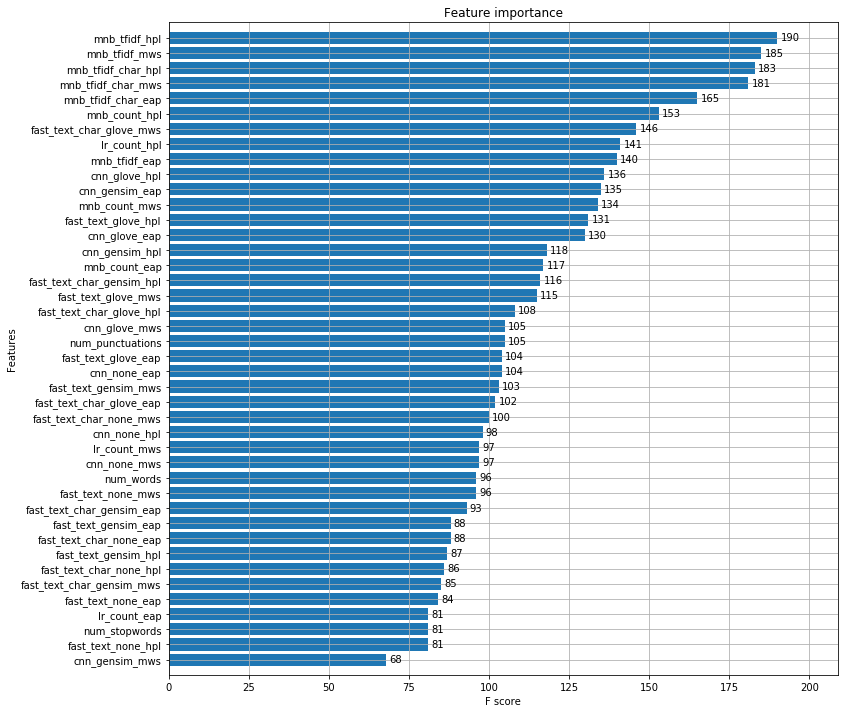

In [55]:
# Run XGboost:
model_name = "xgboost_stacking_final"
model_preprocess_function = run_xgb_preprocess
model_function = run_xgb
model_params = {'seed_val': 0, 'child': 1, 'colsample': 0.3 }
#features_drop = ['num_punctuations','num_stopwords','num_words']
#features_drop = ['svm_tfidf_eap', 'svm_tfidf_hpl','svm_tfidf_mws',
#                'rf_tfidf_eap', 'rf_tfidf_hpl', 'rf_tfidf_mws']
#features_drop = ['fast_text_char_glove_eap', 'fast_text_char_glove_hpl', 'fast_text_char_glove_mws', 
#                 'fast_text_glove_eap', 'fast_text_glove_hpl', 'fast_text_glove_mws', 
#                 'cnn_glove_eap', 'cnn_glove_hpl', 'cnn_glove_mws']
features_drop = None
model_preprocess_params = {'features_drop': features_drop }
pred_train, pred_test, model = run_kfold_training(model_name,
                                           model_preprocess_function, 
                                           model_preprocess_params,
                                           model_function,
                                           model_params,
                                           "VECT", 
                                           train_raw, y_train_raw, test_raw, 0) 
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

In [56]:
create_submission_final("final_submission", pred_test)

Creating submission file: final_submission_submission.csv


### Find number of misclassifications and plot confusion matrix

In [66]:
def find_misclassifications(y_true, pred):
    idx = 0
    num_misclass = 0
    num_correctclass = 0
    for i in y_true:
        true_val = i
        pred_val = np.argmax(pred[idx])
        if true_val != pred_val:
            #print("idx {}, true_val {}, pred_val {}".format(idx, true_val, pred_val))
            #display(train_raw.loc[idx,'text'])
            #display(train_raw.loc[idx,'author'])
            num_misclass += 1
            #break
        else:
            num_correctclass += 1
        idx+=1
    print("num_misclass {}, num_correctclass {}, accuracy {}".format(
                                                            num_misclass, num_correctclass,
                                                            (num_correctclass*100./idx)))
            
find_misclassifications(y_train, pred_train)

num_misclass 2158, num_correctclass 17421, accuracy 88.97798661831554


In [63]:
# Plot confusion matrix:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

19579
Confusion matrix, without normalization
[[7109  315  476]
 [ 428 5006  201]
 [ 557  181 5306]]


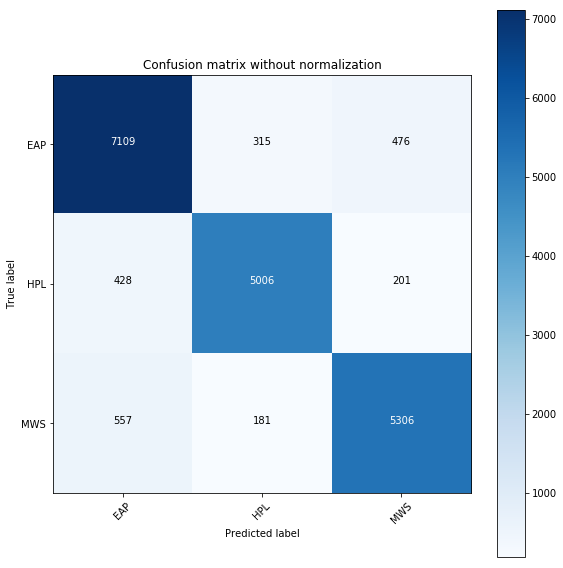

In [64]:
cmatr = confusion_matrix(y_train, np.argmax(pred_train,axis=1))
np.set_printoptions(precision=2)
print(np.sum(cmatr))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cmatr, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix without normalization')
plt.show()

In [131]:
# Check correlation between predictions from different models:

# Get predictions with max probability
new_df = pd.DataFrame()
new_df['mnb_tf'] = train_raw[['mnb_tfidf_eap', 'mnb_tfidf_hpl', 'mnb_tfidf_mws']].idxmax(axis = 1)
new_df['mnb_cnt'] = train_raw[['mnb_count_eap', 'mnb_count_hpl', 'mnb_count_mws'] ].idxmax(axis = 1)
new_df['mnb_tfc'] = train_raw[['mnb_tfidf_char_eap','mnb_tfidf_char_hpl', 'mnb_tfidf_char_mws']].idxmax(axis = 1) 
new_df['lr_cnt'] = train_raw[['lr_count_eap', 'lr_count_hpl', 'lr_count_mws']].idxmax(axis = 1) 
new_df['ft_n'] = train_raw[['fast_text_none_eap', 'fast_text_none_hpl', 'fast_text_none_mws'] ].idxmax(axis = 1)
new_df['ft_gs'] = train_raw[['fast_text_gensim_eap', 'fast_text_gensim_hpl', 'fast_text_gensim_mws']].idxmax(axis = 1) 
new_df['ft_gl'] = train_raw[['fast_text_glove_eap', 'fast_text_glove_hpl', 'fast_text_glove_mws']].idxmax(axis = 1)
new_df['cnn_n'] = train_raw[['cnn_none_eap', 'cnn_none_hpl', 'cnn_none_mws']].idxmax(axis = 1)
new_df['cnn_gs'] = train_raw[['cnn_gensim_eap', 'cnn_gensim_hpl', 'cnn_gensim_mws'] ].idxmax(axis = 1)
new_df['cnn_gl'] = train_raw[['cnn_glove_eap', 'cnn_glove_hpl', 'cnn_glove_mws']].idxmax(axis = 1)
new_df['ftc_n'] = train_raw[['fast_text_char_none_eap','fast_text_char_none_hpl','fast_text_char_none_mws'] ].idxmax(axis = 1)
new_df['ftc_gs'] = train_raw[['fast_text_char_gensim_eap','fast_text_char_gensim_hpl','fast_text_char_gensim_mws']].idxmax(axis = 1)
new_df['ftc_gl'] = train_raw[['fast_text_char_glove_eap', 'fast_text_char_glove_hpl','fast_text_char_glove_mws']].idxmax(axis = 1)

# Convert it to numbers 0,1,2 for authors
display(new_df)
new_df = pd.DataFrame(new_df.applymap(lambda x: re.sub(r'.*_eap$','0',x)))
new_df = pd.DataFrame(new_df.applymap(lambda x: re.sub(r'.*_hpl$','1',x)))
new_df = pd.DataFrame(new_df.applymap(lambda x: re.sub(r'.*_mws$','2',x)))
new_df = new_df.apply(pd.to_numeric)
display(new_df)

,mnb_tf,mnb_cnt,mnb_tfc,lr_cnt,ft_n,ft_gs,ft_gl,cnn_n,cnn_gs,cnn_gl,ftc_n,ftc_gs,ftc_gl
0,mnb_tfidf_eap,mnb_count_eap,mnb_tfidf_char_eap,lr_count_eap,fast_text_none_eap,fast_text_gensim_eap,fast_text_glove_eap,cnn_none_eap,cnn_gensim_eap,cnn_glove_eap,fast_text_char_none_eap,fast_text_char_gensim_eap,fast_text_char_glove_eap
1,mnb_tfidf_mws,mnb_count_eap,mnb_tfidf_char_eap,lr_count_eap,fast_text_none_hpl,fast_text_gensim_mws,fast_text_glove_eap,cnn_none_eap,cnn_gensim_hpl,cnn_glove_eap,fast_text_char_none_hpl,fast_text_char_gensim_eap,fast_text_char_glove_eap
2,mnb_tfidf_eap,mnb_count_eap,mnb_tfidf_char_eap,lr_count_eap,fast_text_none_eap,fast_text_gensim_eap,fast_text_glove_eap,cnn_none_eap,cnn_gensim_eap,cnn_glove_eap,fast_text_char_none_eap,fast_text_char_gensim_eap,fast_text_char_glove_eap
3,mnb_tfidf_mws,mnb_count_mws,mnb_tfidf_char_mws,lr_count_mws,fast_text_none_mws,fast_text_gensim_mws,fast_text_glove_hpl,cnn_none_mws,cnn_gensim_mws,cnn_glove_mws,fast_text_char_none_mws,fast_text_char_gensim_mws,fast_text_char_glove_hpl
4,mnb_tfidf_eap,mnb_count_eap,mnb_tfidf_char_eap,lr_count_eap,fast_text_none_eap,fast_text_gensim_eap,fast_text_glove_hpl,cnn_none_eap,cnn_gensim_eap,cnn_glove_hpl,fast_text_char_none_eap,fast_text_char_gensim_eap,fast_text_char_glove_hpl
5,mnb_tfidf_mws,mnb_count_mws,mnb_tfidf_char_mws,lr_count_mws,fast_text_none_mws,fast_text_gensim_mws,fast_text_glove_mws,cnn_none_mws,cnn_gensim_mws,cnn_glove_mws,fast_text_char_none_mws,fast_text_char_gensim_mws,fast_text_char_glove_mws
6,mnb_tfidf_eap,mnb_count_eap,mnb_tfidf_char_eap,lr_count_eap,fast_text_none_eap,fast_text_gensim_eap,fast_text_glove_eap,cnn_none_eap,cnn_gensim_eap,cnn_glove_eap,fast_text_char_none_eap,fast_text_char_gensim_eap,fast_text_char_glove_eap
7,mnb_tfidf_eap,mnb_count_eap,mnb_tfidf_char_eap,lr_count_eap,fast_text_none_eap,fast_text_gensim_eap,fast_text_glove_eap,cnn_none_eap,cnn_gensim_eap,cnn_glove_eap,fast_text_char_none_eap,fast_text_char_gensim_eap,fast_text_char_glove_eap
8,mnb_tfidf_eap,mnb_count_eap,mnb_tfidf_char_eap,lr_count_eap,fast_text_none_eap,fast_text_gensim_eap,fast_text_glove_eap,cnn_none_eap,cnn_gensim_eap,cnn_glove_eap,fast_text_char_none_eap,fast_text_char_gensim_eap,fast_text_char_glove_eap
9,mnb_tfidf_mws,mnb_count_mws,mnb_tfidf_char_mws,lr_count_mws,fast_text_none_mws,fast_text_gensim_mws,fast_text_glove_eap,cnn_none_mws,cnn_gensim_mws,cnn_glove_eap,fast_text_char_none_mws,fast_text_char_gensim_mws,fast_text_char_glove_eap


,mnb_tf,mnb_cnt,mnb_tfc,lr_cnt,ft_n,ft_gs,ft_gl,cnn_n,cnn_gs,cnn_gl,ftc_n,ftc_gs,ftc_gl
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,1,2,0,0,1,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,2,2,2,2,2,1,2,2,2,2,2,1
4,0,0,0,0,0,0,1,0,0,1,0,0,1
5,2,2,2,2,2,2,2,2,2,2,2,2,2
6,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2,2,2,2,2,2,0,2,2,0,2,2,0


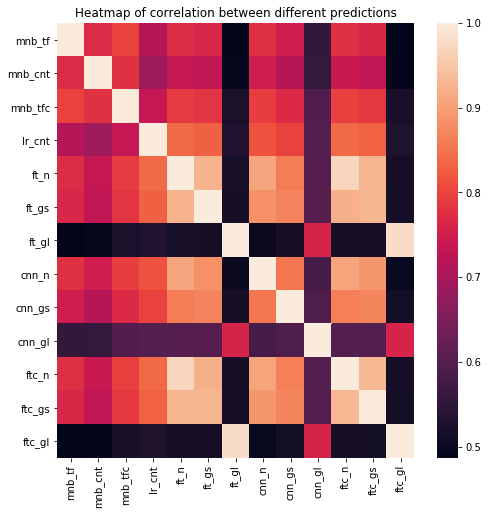

In [134]:
# Plot heatmap of different predictions:
corr = new_df.corr()
plt.figure(figsize = (8,8))
plt.title("Heatmap of correlation between different predictions")
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);
#pd.scatter_matrix(new_df, alpha = 0.3, figsize = (14,8), diagonal = 'kde');